### Loading the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the dataset containing information of BANGALORE cars

In [2]:
df=pd.read_csv('cleaned_bangalore_cars.csv')
df.head()

,Unnamed: 0,id,car_from,it,ft,bt,km,transmission,ownerNo,owner,...,Turbo Charger,Turning Radius,Tyre Type,Value Configuration,Values per Cylinder,Wheel Base,Wheel Size,Width,d,id.3
0,0,0,bangalore,0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,...,No,4.7 metres,"Tubeless, Radial",DOHC,4.0,2425mm,NaN,1635mm,NaN,0
1,1,1,bangalore,0,Petrol,SUV,"32,706",Manual,2,2nd Owner,...,No,5.3 metres,"Tubeless,Radial",DOHC,4.0,2519mm,16,1765mm,NaN,1
2,2,2,bangalore,0,Petrol,Hatchback,"11,949",Manual,1,1st Owner,...,No,4.9 meters,Tubeless,DOHC,4.0,2400mm,14,1647mm,NaN,2
3,3,3,bangalore,0,Petrol,Sedan,"17,794",Manual,1,1st Owner,...,No,4.7 metres,"Tubeless,Radial",DOHC,4.0,2425mm,14,1660mm,NaN,3
4,4,4,bangalore,0,Diesel,SUV,"60,000",Manual,1,1st Owner,...,Yes,5.2 meters,"Tubeless,Radial",DOHC,4.0,2600mm,16,1785mm,NaN,4


In [3]:
df.shape

(1481, 248)

In [4]:
len(df.columns)

248

### Segragating categorical and numerical columns

In [5]:
#categorical columns list
all_cc=[]
#numerical columns list
all_nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        all_cc.append(i)
    else:
        all_nc.append(i)
print('categorical_columns:',all_cc)
print()
print('numerical_columns:',all_nc)

categorical_columns: ['car_from', 'ft', 'bt', 'km', 'transmission', 'owner', 'oem', 'model', 'variantName', 'price', 'priceActual', 'trendingText_heading', 'trendingText_desc', 'Registration Year', 'Insurance Validity', 'Fuel Type', 'Seats', 'Kms Driven', 'RTO', 'Ownership', 'Engine Displacement', 'Transmission', 'Acceleration', 'Alloy Wheel Size', 'BoreX Stroke', 'Cargo Volumn', 'Color', 'Compression Ratio', 'Drive Type', 'Engine', 'Engine Type', 'Front Brake Type', 'Front Tread', 'Fuel Suppy System', 'Gear Box', 'Gross Weight', 'Ground Clearance Unladen', 'Height', 'Kerb Weight', 'Length', 'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Rear Tread', 'Steering Type', 'Super Charger', 'Top Speed', 'Torque', 'Turbo Charger', 'Turning Radius', 'Tyre Type', 'Value Configuration', 'Wheel Base', 'Wheel Size', 'Width']

numerical_columns: ['Unnamed: 0', 'id', 'it', 'ownerNo', 'modelYear', 'centralVariantId', 'priceSaving', 'priceFixedText', 'id.1', 'Year of Manufacture', 'Accessory

In [6]:
# I will use the features in the car_features list along with the features selected using SHAP analysis
car_features=['No Door Numbers', 'No of Cylinder','Values per Cylinder']

### Engineering the 'price' column

In [7]:
x=list(df['price'].apply(lambda x :x.lower()))
am=[]
cu=[]
for i in x:
    try:
        if (i.endswith('e')):
            r=list(i)
            r1=r.index('c')
            am.append(round(float(i[2:r1-1])*10000000,0))
            cu.append(i[r1:])
        elif (i.endswith('h')):
            r=list(i)
            r1=r.index('l')
            am.append(round(float(i[2:r1-1])*100000,0))
            cu.append(i[r1:])
        else:
            d=list(i)
            e=[]
            for j in d:
                if j.isnumeric()==True:
                    e.append(j)
            am.append(float(''.join(e)))
            cu.append('thousand')
    except ValueError:
            am.append(np.nan)
            cu.append(np.nan)

In [8]:
#New price column - this will be the 'target' variable
df['price_new']=am

In [9]:
#Lets take a look at the original and preprocessed price columns
df[['price','price_new']].head()

,price,price_new
0,₹ 4 Lakh,400000.0
1,₹ 8.11 Lakh,811000.0
2,₹ 5.85 Lakh,585000.0
3,₹ 4.62 Lakh,462000.0
4,₹ 7.90 Lakh,790000.0


### Engineering the 'km' column

In [10]:
kms=[]
for i in list(df['km']):
    d=list(i)
    e=[]
    for j in d:
        if j.isnumeric()==True:
            e.append(j)
    kms.append(float(''.join(e)))
    

In [11]:
#new km column
df['kms']=kms

In [12]:
df[['kms','km','Kms Driven']]

,kms,km,Kms Driven
0,120000.0,"1,20,000","1,20,000 Kms"
1,32706.0,"32,706","32,706 Kms"
2,11949.0,"11,949","11,949 Kms"
3,17794.0,"17,794","17,794 Kms"
4,60000.0,"60,000","60,000 Kms"
...,...,...,...
1476,156039.0,"1,56,039","1,56,039 Kms"
1477,56000.0,"56,000","56,000 Kms"
1478,42000.0,"42,000","42,000 Kms"
1479,93003.0,"93,003","93,003 Kms"


### Combining the selected features in the list 'all_selected_features'

In [13]:
all_selected_features=['bt','owner', 'oem','Registration Year','Engine Displacement',
      'Seating Capacity','Alloy Wheel Size','Turbo Charger', 'Engine',  'Front Brake Type',
 'Gear Box', 'Height', 'Kerb Weight', 'Length', 'Max Power', 
'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base','Width','kms','price_new']
for i in car_features:
    all_selected_features.append(i)

In [14]:
df=df[all_selected_features]
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,Max Torque,Mileage,Rear Brake Type,Wheel Base,Width,kms,price_new,No Door Numbers,No of Cylinder,Values per Cylinder
0,Hatchback,3rd Owner,Maruti,2015,998 cc,5.0,NaN,No,998 CC,Ventilated Disc,...,90Nm@3500rpm,23.1 kmpl,Drum,2425mm,1635mm,120000.0,400000.0,5.0,3.0,4.0
1,SUV,2nd Owner,Ford,Feb 2018,1497 cc,5.0,16,No,1497 CC,Ventilated Disc,...,150Nm@4500rpm,17 kmpl,Drum,2519mm,1765mm,32706.0,811000.0,4.0,3.0,4.0
2,Hatchback,1st Owner,Tata,Sept 2018,1199 cc,5.0,14,No,1199 CC,Disc,...,114Nm@3500rpm,23.84 kmpl,Drum,2400mm,1647mm,11949.0,585000.0,5.0,3.0,4.0
3,Sedan,1st Owner,Hyundai,Dec 2014,1197 cc,5.0,14,No,1197 CC,Disc,...,113.75Nm@4000rpm,19.1 kmpl,Drum,2425mm,1660mm,17794.0,462000.0,4.0,4.0,4.0
4,SUV,1st Owner,Maruti,2015,1248 cc,5.0,16,Yes,1248 CC,Ventilated Disc,...,200Nm@1750rpm,23.65 kmpl,Solid Disc,2600mm,1785mm,60000.0,790000.0,5.0,4.0,4.0


In [15]:
df_nv=pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})
df_nv

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,0,8,0.000000
owner,object,0,5,0.000000
oem,object,0,29,0.000000
Registration Year,object,0,179,0.000000
Engine Displacement,object,4,95,0.002701
Seating Capacity,float64,1,7,0.000675
Alloy Wheel Size,object,452,16,0.305199
Turbo Charger,object,193,6,0.130317
Engine,object,3,105,0.002026
Front Brake Type,object,21,17,0.014180


**I will impute the columns having more than 30% missing values and drop null rows having less 3% missing values**

### Engineering the 'bt' column and renaming the new column as 'body_type'

In [16]:
df['body_type']=df['bt'].apply(lambda x:str(x).lower())
df['body_type'].value_counts()

body_type
hatchback        673
suv              409
sedan            337
muv               51
minivans           8
coupe              1
pickup trucks      1
convertibles       1
Name: count, dtype: int64

In [17]:
df['body_type']=['other' if i=='muv' or i=='minivans' or i=='hybrids' or i=='coupe'  else i for i in list(df['body_type'])]
df['body_type'].value_counts()

body_type
hatchback        673
suv              409
sedan            337
other             60
pickup trucks      1
convertibles       1
Name: count, dtype: int64

### Engineering the 'owner' column 

In [18]:
df['owner']=df['owner'].apply(lambda x:x.lower())
df['owner'].value_counts()

owner
1st owner    893
2nd owner    460
3rd owner     95
4th owner     25
5th owner      8
Name: count, dtype: int64

In [19]:
df['owner']=df['owner'].map({'0th owner':'no_owner','1st owner':'1_owner','2nd owner':'2_owners','3rd owner':'>2_owners','4th owner':'>2_owners','5th owner':'>2_owners'})
df['owner'].value_counts()

owner
1_owner      893
2_owners     460
>2_owners    128
Name: count, dtype: int64

### Engineering the 'oem' column 

In [20]:
df['oem']=df['oem'].apply(lambda x:x.lower())
df['oem'].value_counts()

oem
maruti                373
hyundai               313
honda                 137
mahindra               77
tata                   67
renault                67
ford                   61
volkswagen             60
toyota                 53
mercedes-benz          41
bmw                    38
skoda                  37
kia                    27
audi                   24
jeep                   20
mg                     13
nissan                 13
fiat                   10
chevrolet              10
jaguar                  8
volvo                   7
datsun                  6
land rover              4
citroen                 4
mini                    3
mitsubishi              3
opel                    3
mahindra ssangyong      1
mahindra renault        1
Name: count, dtype: int64

In [21]:
car_make=['mg','nissan','jeep','chevrolet','volvo','fiat','land rover','mitsubishi','mini','jaguar','isuzu','citroen',
          'mahindra renault','mahindra ssangyong','lexus']
df['oem']=['other' if i in car_make  else i for i in list(df['oem'])]
df['oem'].value_counts()

oem
maruti           373
hyundai          313
honda            137
other             97
mahindra          77
renault           67
tata              67
ford              61
volkswagen        60
toyota            53
mercedes-benz     41
bmw               38
skoda             37
kia               27
audi              24
datsun             6
opel               3
Name: count, dtype: int64

### Engineering the 'Registration Year' column 

In [22]:
df['registration_year']=df['Registration Year'].apply(lambda x:str(x).lower())
df['registration_year'].value_counts()[:10]

registration_year
2022    53
2018    45
2016    43
2021    40
2012    39
2015    34
2014    33
2010    31
2020    30
2019    28
Name: count, dtype: int64

In [23]:
df['registration_year']=df['Registration Year'].apply(lambda x:x[-4:])
df['registration_year'].value_counts()

registration_year
2018    180
2016    176
2017    171
2019    117
2021    110
2015    106
2020    104
2014     96
2022     90
2012     70
2013     67
2010     46
2011     45
2009     28
2008     19
2006     13
2004     11
2023      9
2007      8
ance      7
2005      4
2003      3
2002      1
Name: count, dtype: int64

In [24]:
ry=['2007','2006','2005','2004','2003','2002',]
df['registration_year']=['before_2008' if i in ry  else i for i in list(df['registration_year'])]
df['registration_year']=['not_specified' if i=='ance' else i for i in list(df['registration_year'])]
df['registration_year'].value_counts()

registration_year
2018             180
2016             176
2017             171
2019             117
2021             110
2015             106
2020             104
2014              96
2022              90
2012              70
2013              67
2010              46
2011              45
before_2008       40
2009              28
2008              19
2023               9
not_specified      7
Name: count, dtype: int64

### Engineering the 'Seating Capacity' column 

In [25]:
df['seating_capacity']=df['Seating Capacity'].apply(lambda x:str(x))
df['seating_capacity'].value_counts()

seating_capacity
5.0     1302
7.0      129
4.0       20
8.0       15
6.0       12
10.0       1
nan        1
9.0        1
Name: count, dtype: int64

In [26]:
df['seating_capacity']=df['seating_capacity'].map({'4.0':'4.0','5.0':'5.0','6.0':'6.0',
                                                      '7.0':'7.0',
                                                      '8.0':'>=8','9.0':'>=8','10.0':'>=8'})
df['seating_capacity'].value_counts()

seating_capacity
5.0    1302
7.0     129
4.0      20
>=8      17
6.0      12
Name: count, dtype: int64

In [27]:
df.fillna({'seating_capacity':'5.0'},inplace=True)

### Engineering the 'Engine Displacement' column 

In [28]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
df['engine_displacement'].value_counts()[:50]

engine_displacement
1197 cc      319
manual       124
998 cc       101
1199 cc       94
1497 cc       65
999 cc        60
automatic     49
1498 cc       47
2179 cc       42
1248 cc       42
1591 cc       32
1198 cc       30
1995 cc       26
1396 cc       25
1461 cc       25
1956 cc       21
1462 cc       19
796 cc        18
1086 cc       18
1582 cc       17
1493 cc       16
1598 cc       16
1968 cc       16
2143 cc       15
1496 cc       13
1368 cc       12
2494 cc       11
1999 cc       10
2982 cc       10
1798 cc       10
1353 cc        9
2993 cc        7
1196 cc        7
1373 cc        6
1969 cc        6
1997 cc        6
1998 cc        6
2987 cc        6
1499 cc        6
814 cc         5
1451 cc        5
1298 cc        5
2967 cc        5
1991 cc        5
1950 cc        4
2755 cc        4
2354 cc        4
1399 cc        4
1341 cc        4
nan            4
Name: count, dtype: int64

In [29]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
ed=[]
for i in list(df['engine_displacement']):
    d=list(i)
    e=[]
    if i=='nan':
        ed.append(np.nan)
    elif i=='automatic':
        ed.append(9)
    elif i=='manual':
        ed.append(6)
    else:
        for j in d:
            if j.isnumeric()==True:
                e.append(j)

        
        ed.append(float(''.join(e)))
        
print(len(ed))    
df['engine_displacement']=ed
print(df['engine_displacement'].value_counts().sort_values())
print(set(ed))

1481
engine_displacement
1586.0      1
1996.0      1
1364.0      1
3597.0      1
2200.0      1
         ... 
1497.0     65
1199.0     94
998.0     101
6.0       124
1197.0    319
Name: count, Length: 95, dtype: int64
{nan, 0.0, 6, 9, 3597.0, 1047.0, 1061.0, 1582.0, 1586.0, 1590.0, 1591.0, 1595.0, 1596.0, 1597.0, 1086.0, 1598.0, 72.0, 1108.0, 2143.0, 1120.0, 624.0, 3198.0, 2179.0, 2694.0, 2696.0, 2184.0, 2198.0, 2199.0, 2200.0, 1194.0, 1196.0, 1197.0, 1198.0, 1199.0, 2755.0, 1248.0, 1781.0, 1797.0, 1798.0, 1298.0, 796.0, 799.0, 814.0, 2354.0, 1330.0, 1332.0, 2362.0, 1341.0, 1353.0, 1364.0, 1368.0, 2393.0, 1373.0, 2400.0, 1896.0, 2925.0, 1390.0, 1389.0, 1395.0, 1396.0, 1397.0, 1399.0, 1405.0, 2967.0, 1950.0, 1956.0, 2982.0, 2987.0, 1451.0, 1968.0, 1969.0, 2993.0, 1461.0, 1462.0, 2494.0, 2496.0, 1984.0, 2498.0, 2499.0, 1991.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 1493.0, 1495.0, 1496.0, 1497.0, 1498.0, 1499.0, 2523.0, 993.0, 995.0, 998.0, 999.0}


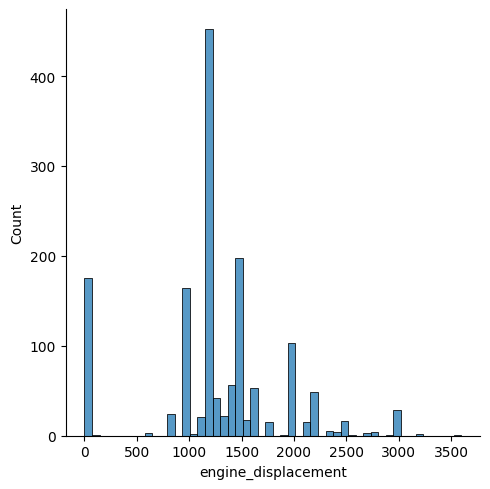

mean: 1263.8171970209885 median: 1198.0


In [30]:
sns.displot(df['engine_displacement'])
plt.show()
print('mean:',df['engine_displacement'].mean(),'median:',df['engine_displacement'].median())

In [31]:
df.fillna({'engine_displacement':df['engine_displacement'].median()},inplace=True)

### Engineering the 'Alloy Wheel Size' column 

In [32]:
df['alloy_wheel_size']=df['Alloy Wheel Size'].apply(lambda x:str(x).lower())
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
nan    452
16     316
15     201
17     156
14     132
13      66
18      66
r16     25
19      16
r15     12
12      10
r18      9
r17      9
20       4
r14      3
r19      2
21       2
Name: count, dtype: int64

In [33]:
al=[]
for i in list(df['alloy_wheel_size']):
    if i=='nan':
        al.append(np.nan)
    elif i[0]!='r':
        al.append(f'r{i}')
    else:
        al.append(i)
df['alloy_wheel_size']=al
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
r16    341
r15    213
r17    165
r14    135
r18     75
r13     66
r19     18
r12     10
r20      4
r21      2
Name: count, dtype: int64

In [34]:
df.fillna({'alloy_wheel_size':'r16'},inplace=True)

In [35]:
df['alloy_wheel_size'].isnull().sum()

0

### Engineering the 'Turbo Charger' column

In [36]:
df['turbo_charger']=df['Turbo Charger'].apply(lambda x:str(x).lower())
print(df['turbo_charger'].value_counts())

turbo_charger
no      745
yes     535
nan     193
twin      8
Name: count, dtype: int64


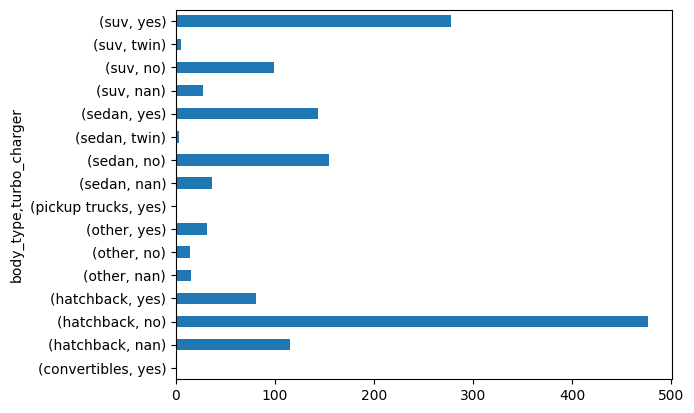

In [37]:
df.groupby(['body_type','turbo_charger'])['turbo_charger'].count().plot(kind='barh')
plt.show()

In [38]:
z=list(df[df['turbo_charger']=='nan']['body_type'])
z

['hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'suv',
 'hatchback',
 'hatchback',
 'other',
 'hatchback',
 'suv',
 'sedan',
 'hatchback',
 'sedan',
 'sedan',
 'sedan',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'suv',
 'suv',
 'suv',
 'hatchback',
 'hatchback',
 'sedan',
 'sedan',
 'hatchback',
 'other',
 'hatchback',
 'hatchback',
 'other',
 'hatchback',
 'hatchback',
 'suv',
 'hatchback',
 'sedan',
 'suv',
 'hatchback',
 'hatchback',
 'suv',
 'sedan',
 'hatchback',
 'hatchback',
 'suv',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'suv',
 'hatchback',
 'hatchback',
 'other',
 'suv',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'other',
 'sedan',
 'hatchback',
 'suv',
 'sedan'

In [39]:
for h in range(len(z)):
    if z[h]=='suv' or z[h]=='other':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='yes'
    elif z[h]=='hatchback' or z[h]=='sedan':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='no'

In [40]:
df['turbo_charger'].isnull().sum()

0

### Engineering the 'Front Brake Type' column

In [41]:
df.columns

Index(['bt', 'owner', 'oem', 'Registration Year', 'Engine Displacement',
       'Seating Capacity', 'Alloy Wheel Size', 'Turbo Charger', 'Engine',
       'Front Brake Type', 'Gear Box', 'Height', 'Kerb Weight', 'Length',
       'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base',
       'Width', 'kms', 'price_new', 'No Door Numbers', 'No of Cylinder',
       'Values per Cylinder', 'body_type', 'registration_year',
       'seating_capacity', 'engine_displacement', 'alloy_wheel_size',
       'turbo_charger'],
      dtype='object')

In [42]:
df['front_brake_type']=df['Front Brake Type'].apply(lambda x:str(x).lower())
print(df['front_brake_type'].value_counts())

front_brake_type
disc                      971
ventilated disc           436
nan                        21
ventilated discs           15
disc & caliper type        11
disc                        9
solid disc                  4
ventilated disc             3
disk                        3
drum                        2
electric parking brake      2
 disc                       1
disc, 236 mm                1
multilateral disc           1
 ventilated disc            1
Name: count, dtype: int64


In [43]:
df['front_brake_type'].unique()

array(['ventilated disc', 'disc', 'disc ', ' disc', 'disc & caliper type',
       'ventilated discs', 'ventilated disc ', 'nan', 'disc, 236 mm',
       'multilateral disc', 'solid disc', 'disk', 'drum',
       'electric parking brake', ' ventilated disc'], dtype=object)

In [44]:
df['front_brake_type']=df['front_brake_type'].map({'disc':'solid disc','ventilated disc':'ventilated discs',
                                                   'ventilated discs':'ventilated discs','disc ':'solid disc',
                                                   'solid disc':'solid disc','disk':'solid disc','ventilated disk':'ventilated discs',
                                                   'ventilated disc ':'ventilated discs','vantilated disc':'ventilated discs',
                                                   'ventlated disc':'ventilated discs','disc, 236 mm':'solid disc','nan':'solid disc',
                                                   'drum':'other','multilateral disc':'other','disc & caliper type':'other',
                                                   'booster assisted ventilated disc':'other','caliper ventilated disc':'other',
                                                   'abs':'other'})
print(df['front_brake_type'].value_counts())

front_brake_type
solid disc          1009
ventilated discs     454
other                 14
Name: count, dtype: int64


### Engineering the 'Gear Box' column

In [45]:
df['gear_box']=df['Gear Box'].apply(lambda x:str(x).lower())
print(df['gear_box'].value_counts())

gear_box
5 speed                                            732
6 speed                                            201
5-speed                                            106
7 speed                                             56
6-speed                                             53
8 speed                                             41
4 speed                                             39
cvt                                                 32
6 speed                                             27
5 speed                                             25
nan                                                 24
5                                                   18
9 speed                                             15
7-speed dct                                         13
5 speed cvt                                         11
6-speed imt                                          8
7-speed                                              7
five speed manual                                    6
8

In [46]:
df['gear_box'].unique()

array(['5 speed ', '5 speed', '6 speed', '7-speed', '4 speed', '6 speed ',
       '8g-dct', '5-speed', '7 speed', '9 speed', '8 speed',
       '8-speed steptronic', '6-speed', '7-speed dct', '9-speed',
       '8 speed tiptronic', '5', '6 speed imt', '6-speed autoshift',
       '6-speed cvt', 'cvt', '7 speed dsg', '7 speed dct', '6', '8-speed',
       '8-speed steptronic sport automatic transmission', '7 speed cvt',
       'five speed manual', '5 speed cvt', 'nan', '6 speed at',
       '6-speed imt', '6-speed dct', '7-speed s-tronic ',
       '7g dct 7-speed dual clutch transmission ', '7-speed s-tronic',
       '5-speed`', '9 speed tronic', '6-speed ivt', 'direct drive',
       '6 speed ivt', 'ivt', '8 speed cvt',
       'five speed manual transmission', '5 speed at+ paddle shifters',
       '8-speed ', 'imt', 'ags', '6speed', '4-speed', '6 speed mt'],
      dtype=object)

In [47]:
gb=[]
for i in list(df['gear_box']):
    if i=='5 speed' or i=='5-speed' or i=='5 speed ' or i=='5' or i=='five speed' :
        gb.append('5 speed')
    elif i=='five speed manual transmission gearbox' :
        gb.append('5 speed manual transmission')
    elif i=='five speed manual transmission':
        gb.append('5 speed manual transmission')
    elif i in ['7 speed ','7-speed']:
        gb.append('7 speed')
    elif i in ['7-speed stronic','7-speed s-tronic','7-speed s-tronic ']:
        gb.append('7-speed s-tronic')
    elif i in [ '7 speed dct','7-speed dct']:
        gb.append( '7 speed dct')
    elif i in ['8-speed','8', '8-speed ','8 speed ']:
        gb.append('8 speed')
    elif i in ['6 speed ','6-speed','6']:
        gb.append('6 speed')
    elif i in ['6-speed at','6-speed at' ,'6 speed at',]:
        gb.append('6-speed at')
    elif i in ['six speed manual',]:
        gb.append('6-speed manual') 
    else:
        gb.append(i)
        

In [48]:
df['gear_box']=gb
print(df['gear_box'].value_counts())

gear_box
5 speed                                            881
6 speed                                            282
7 speed                                             63
8 speed                                             48
4 speed                                             39
cvt                                                 32
nan                                                 24
7 speed dct                                         19
9 speed                                             15
5 speed cvt                                         11
6-speed imt                                          8
8-speed steptronic                                   6
five speed manual                                    6
6 speed imt                                          5
8 speed tiptronic                                    4
7-speed s-tronic                                     4
7 speed dsg                                          3
ags                                                  2
i

In [49]:
x=list(df['gear_box'])
gb1=['other' if x.count(i)<10 else i for i in x ]

In [50]:
df['gear_box']=gb1
print(df['gear_box'].value_counts())

gear_box
5 speed        881
6 speed        282
other           67
7 speed         63
8 speed         48
4 speed         39
cvt             32
nan             24
7 speed dct     19
9 speed         15
5 speed cvt     11
Name: count, dtype: int64


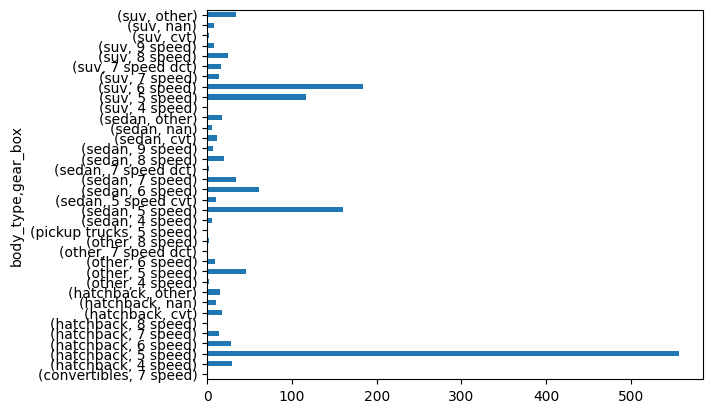

In [51]:
df.groupby(['body_type','gear_box'])['gear_box'].count().plot(kind='barh')
plt.show()

In [52]:
df.fillna({'gear_box':'5 speed'},inplace=True)

In [53]:
df['gear_box'].isnull().sum()

0

### Engineering the 'Mileage' column

In [54]:
df['mileage']=df['Mileage'].apply(lambda x:str(x).lower())
print(df['mileage'].value_counts())

mileage
18.9 kmpl     72
22.38 kmpl    46
18.6 kmpl     44
21.4 kmpl     43
nan           42
              ..
11.57 kmpl     1
15.26 kmpl     1
13.79 kmpl     1
16.13 kmpl     1
21.8 kmpl      1
Name: count, Length: 318, dtype: int64


In [55]:
avs=[]
for i in list(df['mileage']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['mileage']=avs
df['mileage'].value_counts()

mileage
19.0     219
18.0     163
22.0     157
21.0     145
17.0     134
20.0     108
16.0     100
15.0      75
23.0      68
14.0      54
13.0      54
24.0      42
25.0      36
12.0      24
11.0      17
26.0      14
27.0      13
28.0       5
8.0        3
10.0       3
9.0        2
110.0      1
140.0      1
32.0       1
Name: count, dtype: int64

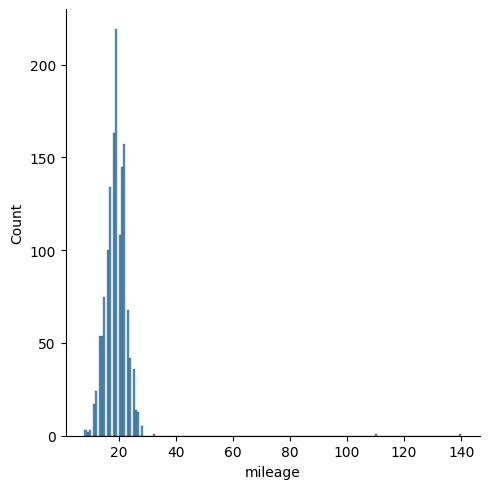

mean: 19.02084781097985 median: 19.0


In [56]:
sns.displot(df['mileage'])
plt.show()
print('mean:',df['mileage'].mean(),'median:',df['mileage'].median())

In [57]:
df.fillna({'mileage':df['mileage'].median()},inplace=True)

In [58]:
df['mileage'].isnull().sum()

0

### Engineering the 'Wheel Base' column

In [59]:
df['wheel_base' ]=df['Wheel Base' ].apply(lambda x:str(x).lower())
print(df['wheel_base' ].value_counts())

wheel_base
2425mm     88
2450       75
2570mm     69
2520mm     68
2600mm     68
           ..
3060        1
3105 mm     1
2975 mm     1
3014        1
2703 mm     1
Name: count, Length: 176, dtype: int64


In [60]:
avs=[]
for i in list(df['wheel_base']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['wheel_base']=avs
df['wheel_base'].value_counts()

wheel_base
2450.0    132
2425.0     88
2600.0     76
2520.0     71
2570.0     69
         ... 
2841.0      1
2467.0      1
2648.0      1
2010.0      1
2703.0      1
Name: count, Length: 129, dtype: int64

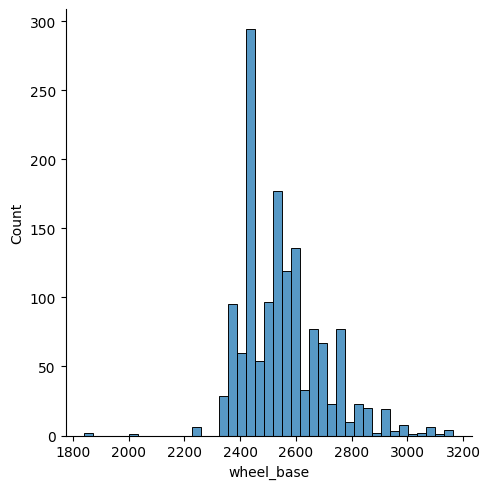

mean: 2551.9363762102353 median: 2520.0


In [61]:
sns.displot(df['wheel_base'])
plt.show()
print('mean:',df['wheel_base'].mean(),'median:',df['wheel_base'].median())

In [62]:
df.fillna({'wheel_base':df['wheel_base'].median()},inplace=True)

In [63]:
df['wheel_base'].isnull().sum()

0

### Engineering the 'Height' column

In [64]:
df['height' ]=df['Height'].apply(lambda x:str(x).lower())
print(df['height'].value_counts())

height
1505mm     81
1520mm     67
1510mm     58
1475mm     55
1530       53
           ..
1490 mm     1
1616mm      1
1572mm      1
1465mm      1
1488 mm     1
Name: count, Length: 223, dtype: int64


In [65]:
avs=[]
for i in list(df['height']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['height']=avs
df['height'].value_counts()

height
1530.0    99
1505.0    90
1520.0    76
1510.0    58
1475.0    56
          ..
1534.0     1
1670.0     1
1626.0     1
1651.0     1
1488.0     1
Name: count, Length: 173, dtype: int64

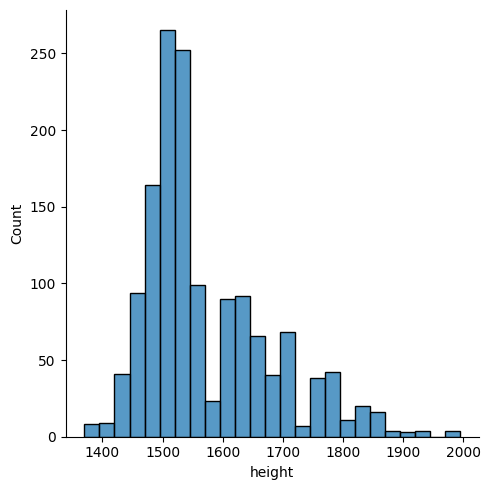

mean: 1570.1260273972603 median: 1530.0


In [66]:
sns.displot(df['height'])
plt.show()
print('mean:',df['height'].mean(),'median:',df['height'].median())

In [67]:
df.fillna({'height':df['height'].median()},inplace=True)

### Engineering the 'Kerb Weight' column

In [68]:
df['kerb_weight' ]=df['Kerb Weight'].apply(lambda x:str(x).lower())
print(df['kerb_weight'].value_counts())
df['kerb_weight'].unique()

kerb_weight
875-905    53
1066kg     39
1120       31
935kg      28
880kg      17
           ..
1585        1
1085        1
1845        1
2000kg      1
1970kg      1
Name: count, Length: 455, dtype: int64


array(['835kg', '1242kg', '1012kg', '1180', '1230kg', '1551 kgs', '1070',
       '1440', '1105', '870kg', '1200', '1066 kg', '1900', '1562 kgs',
       '1675', '1120', '1315', '1049kg', '1600kg', '875-905', '2200kg',
       '1050', '845', '1585', '1595kg', '1940', '1650', '1140', '885kg',
       '1170 kg', '1655kg', '1955 kg', '1375', '1066kg', '1515kg',
       '880kg', '1329kg', '1735kg', '762kg', '1990', '1250kg', '1535',
       '1980', '705kg', '2535kg', '1825kg', '1060', '2345kg', '1970',
       '750', '1305kg', '1095kg', '815', '1206kg', '1225kg', '1320',
       '1700', '960kg', '850kg', '1720', '1105kg', '1360kg', '1376kg',
       '980kg', '1015kg', '1260', '1380', '1192kg', '1025kg', '1040',
       '1135', '1865', '890kg', '860kg', '730', '1652kg', '1835', '1345',
       '1820', '925kg', '910-935', '760kg', '1086', '910', '1179kg',
       '1525', '1730', '900', '1300', '1465', '2020', '1350kg', '840kg',
       '1445kg', '1580', '1608kg', '960', '1100', '1830kg', '755', '1020',
 

In [69]:
avs=[]
for i in list(df['kerb_weight']):
    if i=='nan' or i=='kerb weight':
        avs.append(np.nan)
    
    elif i[0].isnumeric()==True:
        
        b=[]
        if '-' in list(i):
            r=i.index('-')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['kerb_weight']=avs
df['kerb_weight'].value_counts()

kerb_weight
875.0     53
1066.0    44
880.0     32
1120.0    31
935.0     28
          ..
2160.0     1
2095.0     1
1380.0     1
1192.0     1
1163.0     1
Name: count, Length: 319, dtype: int64

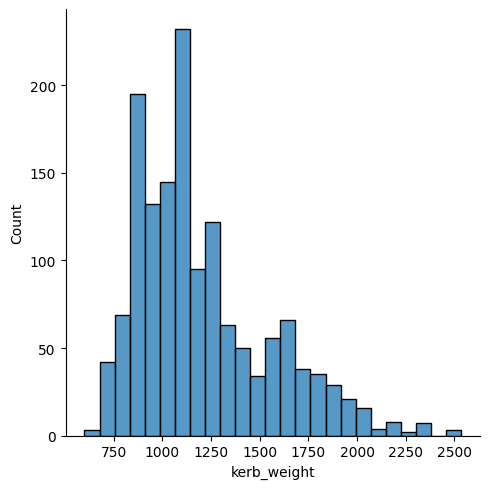

mean: 1202.4287661895023 median: 1105.0


In [70]:
sns.displot(df['kerb_weight'])
plt.show()
print('mean:',df['kerb_weight'].mean(),'median:',df['kerb_weight'].median())

In [71]:
df.fillna({'kerb_weight':df['kerb_weight'].median()},inplace=True)

### Engineering the 'Length' column

In [72]:
df['length' ]=df['Length'].apply(lambda x:str(x).lower())
print(df['length'].value_counts())
df['length'].unique()

length
3995mm    153
3765mm     63
3985mm     59
4440mm     58
3845mm     53
         ... 
4629mm      1
3640mm      1
4815mm      1
3886mm      1
4107mm      1
Name: count, Length: 242, dtype: int64


array(['3715mm', '3998mm', '3746mm', '3995mm', '4300mm', '4395mm',
       '3785mm', '3995 mm', '4490 mm', '3765mm', '3955 mm', '4585mm',
       '4436mm', '3993', '4440mm', '4841mm', '3845mm', '4360', '5246mm',
       '3610 mm', '3565mm', '5063mm', '4701mm', '4405mm', '3599mm',
       '4395 mm', '4686mm', '4936mm', '4695 mm', '3985mm', '4530mm',
       '4933mm', '3445mm', '4430mm', '3850mm', '4315mm', '5075mm',
       '3495mm', '5120mm', '4661mm', '5089mm', '3731mm', '3994mm',
       '3810mm', '3695mm', '4386mm', '4270mm', '4598mm', '3840mm',
       '4824mm', '4490mm', '3955mm', '4498mm', '4670mm', '3775mm',
       '3970mm', '4413mm', '3675mm', '4708', '3636mm', '3585mm', '3679mm',
       '4635mm', '4720mm', '3610mm', '3620mm', '3991mm', '4390mm',
       '4425mm', '4655mm', '4500mm', '4234mm', '4531mm', '4838mm',
       '4629mm', '3530mm', '3940 mm', '4892mm', '3886mm', '3700mm',
       '4886mm', '4520mm', '4475mm', '4795mm', '4598 mm', '4656 mm',
       '4331mm', '3971mm', '4575mm', '4

In [73]:
avs=[]
for i in list(df['length']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['length']=avs
df['length'].value_counts()

length
3995.0    181
3765.0     65
4440.0     60
3985.0     59
3845.0     53
         ... 
4629.0      1
4815.0      1
3886.0      1
4475.0      1
4107.0      1
Name: count, Length: 208, dtype: int64

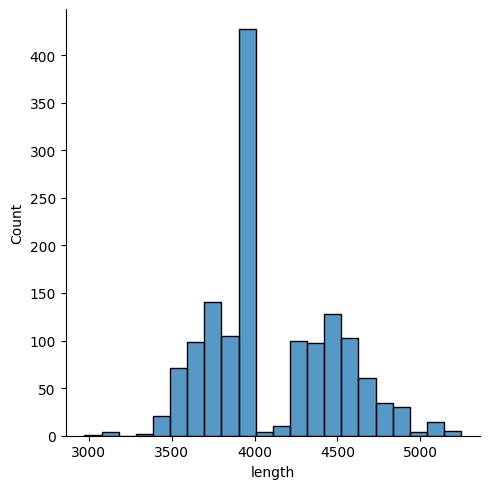

mean: 4112.510958904109 median: 3995.0


In [74]:
sns.displot(df['length'])
plt.show()
print('mean:',df['length'].mean(),'median:',df['length'].median())

In [75]:
df.fillna({'length':df['length'].median()},inplace=True)

### Engineering the 'Max Power' column

In [76]:
df['max_power']=df['Max Power'].apply(lambda x:str(x).lower())
print(df['max_power'].value_counts())
df['max_power'].unique()

max_power
88.50bhp     73
81.86bhp     58
81.80bhp     54
88.7bhp      49
83.1bhp      43
             ..
281.61bhp     1
145hp         1
164.7bhp      1
89.84bhp      1
104.68        1
Name: count, Length: 280, dtype: int64


array(['67.04bhp', '121.31bhp', '84bhp', '81.86bhp', '88.5bhp', '170bhp',
       '67bhp', '118.35bhp', '103.25bhp', '83.1bhp', '88.7bhp',
       '83.83bhp', '140bhp', '187.74bhp', '88.76bhp', '117.3bhp', '177 ',
       '88.50bhp', '104.55bhp', '453.26bhp', '68bhp', '62.1bhp',
       '194.4bhp', '174.33bhp', '167.67bhp', '103bhp', '194bhp',
       '248.08bhp', '171 ps ', '108.5bhp', '81.83bhp', '88.73bhp',
       '147.5bhp', '47.33bhp', '120bhp', '189.08bhp', '138.08bhp',
       '281.61bhp', '46.3bhp', '254.8bhp', '241.4bhp', '83 ps ',
       '65.71bhp', '103.52bhp', '120.69bhp', '126.2bhp', '74bhp',
       '188bhp', '178bhp', '85.80bhp', '118.36bhp', '116.3bhp',
       '103.6bhp', '108.6bhp', '70bhp', '82.85bhp', '77bhp', '68.05bhp',
       '190bhp', '141bhp', '86.8bhp', '81.80bhp', '67.1bhp', '71.01bhp',
       '55.2bhp', '103.2bhp', '105.5bhp', '167.68bhp', '156.9bhp',
       '121.3bhp', '138.12bhp', '147.94bhp', '170 ', '160.77bhp',
       '138.1bhp', '78.9bhp', '102.57bhp', '174.3b

In [77]:
a=[]
for i in list(df['max_power']):
    if 'bhp' not in i:
        a.append(i)
print(set(a))

{'70', '70 ', '88.2', '83 ps ', '118ps at 6,600 rpm', '177 ', '120 ', '57 ', '145hp', '101 ', '94 ', '171 ps ', '106', '68', 'nan', '78 kw ', '174.33', '260.0 ', '75', '170 ', '163.2', '103.2 ps at 5500 rpm', '115 ', '93 ps ', '215 ', '61 ps ', '90 ps ', '88 ps ', '60 ps ', '218 ', '94 ps ', '104.68', '80 ', '80 ps at 5200 rpm', '92', '68 ', '102', '78 ', '112.2 ', '161.6 '}


In [78]:
avs=[]
for i in list(df['max_power']):
    if i=='nan':
        avs.append(np.nan)
    elif i=='66(90) / 4000' or i=='90(66) ':
        avs.append(65)
    elif i=='118ps at 6,600 rpm':
        avs.append(116.39)
    elif i=='105 ps at 5250 rpm':
        avs.append(103.56)
    elif i=='90ps at 4000rpm':
        avs.append(78.91)
    elif i=='80 ps at 5200 rpm':
        avs.append(99.77)
    elif i=='63 hp at 3200 rpm':
        avs.append(63)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['max_power']=avs
df['max_power'].value_counts()

max_power
82.0      166
88.0       91
67.0       83
89.0       79
83.0       58
         ... 
148.0       1
1123.0      1
246.0       1
335.0       1
296.0       1
Name: count, Length: 129, dtype: int64

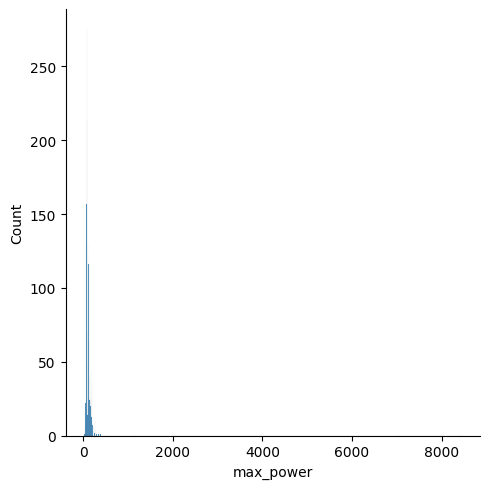

mean: 117.44948122866893 median: 89.0


In [79]:
sns.displot(df['max_power'])
plt.show()
print('mean:',df['max_power'].mean(),'median:',df['max_power'].median())

In [80]:
df.fillna({'max_power':df['max_power'].median()},inplace=True)

### Engineering the 'Max Torque' column

In [81]:
df['max_torque' ]=df['Max Torque'].apply(lambda x:str(x).lower())
print(df['max_torque' ].value_counts())
df['max_torque' ].unique()

max_torque
113nm@4400rpm          70
113nm@4200rpm          54
110nm@4800rpm          54
90nm@3500rpm           53
115nm@4000rpm          46
                       ..
110nm                   1
70nm@1000rpm            1
226nm@4400rpm           1
400nm@2800rpm           1
145@4,100 (kgm@rpm)     1
Name: count, Length: 288, dtype: int64


array(['90nm@3500rpm', '150nm@4500rpm', '114nm@3500rpm',
       '113.75nm@4000rpm', '200nm@1750rpm', '350nm@1750-2500rpm',
       '104nm@4000rpm', '171.6nm@1500-4000rpm', '138nm@4400rpm',
       '115nm@4000rpm', '110nm@4800rpm', '330nm@1600-2800rpm',
       '400nm@1600-2600rpm', '219.6nm@1500-2750rpm', '170nm@1750-4000rpm',
       '145nm@4600rpm', '35.7 @ 1,750-3,000 (kgm@rpm)', '113nm@4400rpm',
       '142nm @ 4000rpm', '700nm@1800-3500rpm', '99nm@4500 rpm',
       '96.1nm@3000rpm', '300nm@1600-4000rpm', '380nm@1750-2500rpm',
       '400nm@1600-2800rpm', '350nm@1450-4800rpm',
       '343 nm @ 1400-3400 rpm', '245nm@1750rpm', '114.7nm@4000rpm',
       '219.7nm@1500-2750rpm', '177.5nm@4700rpm', '400nm@1750-3000rpm',
       '69nm@3500rpm', '290nm@1800-2800rpm', '280nm@1250rpm',
       '242nm@1500-3200rpm', '600nm@1200-3200rpm', '62nm@3000rpm',
       '117nm@4000rpm', '619nm@1600-2400rpm', '550nm@1750-2750rpm',
       '91nm@4250rpm', '260nm@1500-2750rpm', '115 nm @ 3200 rpm ',
       '89n

In [82]:
s=[i if '15' in i else 'a' for i in list(df['max_torque'])]
s

['a',
 '150nm@4500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 '171.6nm@1500-4000rpm',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '219.6nm@1500-2750rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '219.7nm@1500-2750rpm',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '242nm@1500-3200rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '260nm@1500-2750rpm',
 '115 nm @ 3200 rpm ',
 'a',
 '250nm@1500-2500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '171.62nm@1500-4000rpm',
 'a',
 '175nm@1500-4100rpm',
 '250nm@1500-2500rpm',
 '160nm@1500-2750rpm',
 'a',
 'a',
 '219.6nm@1500-2750rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '242nm@1500-3200rpm',
 'a',
 '175nm@1500-4100rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 '151nm@4850rpm',
 '219.6nm@1500-2750rpm',
 '242nm@1500-3200r

In [83]:
avs=[]
for i in list(df['max_torque']):
    if i=='nan' :
        avs.append(np.nan)
    elif i=='11.4 kgm at 4,000 rpm':
        avs.append(round(111.79581))
    elif i=='22.4 kgm at 1750-2750rpm':
        avs.append(round(219.67))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(132.38))
    elif i=='180 nm at 1440-1500rpm':
        avs.append(round(180))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(219.87))
    elif i=='155 nm at 1600-2800 rpm':
        avs.append(round(155))  
    elif i=='210 / 1900':
        avs.append(round(210)) 
    elif i=='135 nm @ 2500 rpm ':
        avs.append(round(135)) 
    elif i=='148  nm @ 3500  rpm':
        avs.append(round(148))
    elif i=='146nm at 4800 rpm':
        avs.append(round(146))
    
    elif i[0].isnumeric()==True:
        b=[]
        if '@' in list(i):
            r=i.index('@')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['max_torque']=avs
df['max_torque'].value_counts()

max_torque
1.130000e+02    132
1.140000e+02    102
1.150000e+02     90
1.100000e+02     65
2.000000e+02     57
               ... 
7.800000e+01      1
3.190000e+02      1
2.601800e+10      1
1.820000e+02      1
2.090000e+02      1
Name: count, Length: 135, dtype: int64

In [84]:
max(avs)

26018002200

In [85]:
# sns.displot(df['max_torque'])
# plt.show()
print('mean:',df['max_torque'].mean(),'median:',df['max_torque'].median())

mean: 17759905.25324232 median: 140.0


In [86]:
df.fillna({'max_torque':df['max_torque'].median()},inplace=True)

### Engineering the 'Width' column

In [87]:
df['width' ]=df['Width'].apply(lambda x:str(x).lower())
print(df['width'].value_counts())
df['width'].unique()

width
1695mm      74
1735        69
1660mm      67
1734mm      62
1745mm      59
            ..
1,686 mm     1
1670         1
1725mm       1
2065mm       1
1813 mm      1
Name: count, Length: 198, dtype: int64


array(['1635mm', '1765mm', '1647mm', '1660mm', '1785mm', '1818mm',
       '1770 mm', '1730 mm', '1745mm', '1694 mm', '1890mm', '2020mm',
       '1710mm', '1811', '1695mm', '1846mm', '1735', '1822', '2130mm',
       '1645 mm', '1525mm', '1860mm', '2040mm', '1495mm', '1735 mm',
       '2126mm', '1840 mm', '1734mm', '1775mm', '1874mm', '1515mm',
       '1817mm', '1727mm', '1800mm', '2065mm', '1475mm', '2141mm',
       '1894mm', '2177mm', '1579mm', '1811mm', '1665mm', '1655', '1699mm',
       '1780mm', '1735mm', '1828mm', '1730mm', '1694mm', '1751mm',
       '1814mm', '1680mm', '1682mm', '1715mm', '2138', '1595mm', '2097mm',
       '1821 mm', '1835mm', '1750', '1550mm', '1790mm', '1819mm',
       '1822mm', '2089mm', '1490', '1710 mm', '1690mm', '1739', '1938mm',
       '1850mm', '1855mm', '1894 mm', '1729mm', '1890 mm', '2000mm',
       '1820mm', '1992mm', '1760mm', '1902mm', '1813mm', '1,730 mm',
       '1900mm', '1854mm', '1776mm', '1730', '1,634 mm', '2218 mm',
       '1877mm', '1796mm'

In [88]:
avs=[]
for i in list(df['width']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['width']=avs
df['width'].value_counts()

width
1735.0    117
1695.0     80
1660.0     67
1734.0     63
1745.0     62
         ... 
2195.0      1
1727.0      1
1683.0      1
1769.0      1
2220.0      1
Name: count, Length: 150, dtype: int64

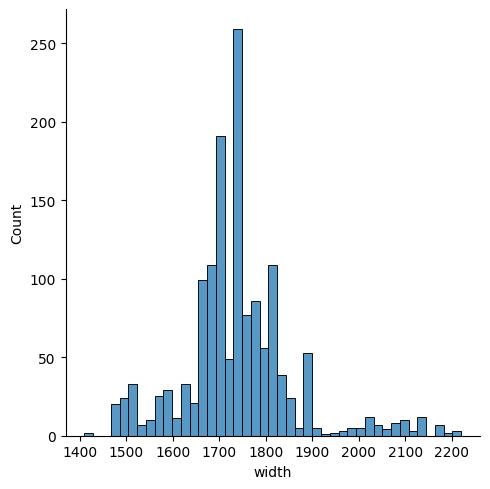

mean: 1739.0602739726028 median: 1735.0


In [89]:
sns.displot(df['width'])
plt.show()
print('mean:',df['width'].mean(),'median:',df['width'].median())

In [90]:
df.fillna({'width':df['width'].median()},inplace=True)

In [91]:
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,front_brake_type,gear_box,mileage,wheel_base,height,kerb_weight,length,max_power,max_torque,width
0,Hatchback,>2_owners,maruti,2015,998 cc,5.0,NaN,No,998 CC,Ventilated Disc,...,ventilated discs,5 speed,23.0,2425.0,1565.0,835.0,3715.0,67.0,90.0,1635.0
1,SUV,2_owners,ford,Feb 2018,1497 cc,5.0,16,No,1497 CC,Ventilated Disc,...,ventilated discs,5 speed,17.0,2519.0,1647.0,1242.0,3998.0,121.0,150.0,1765.0
2,Hatchback,1_owner,tata,Sept 2018,1199 cc,5.0,14,No,1199 CC,Disc,...,solid disc,5 speed,24.0,2400.0,1535.0,1012.0,3746.0,84.0,114.0,1647.0
3,Sedan,1_owner,hyundai,Dec 2014,1197 cc,5.0,14,No,1197 CC,Disc,...,solid disc,5 speed,19.0,2425.0,1520.0,1180.0,3995.0,82.0,114.0,1660.0
4,SUV,1_owner,maruti,2015,1248 cc,5.0,16,Yes,1248 CC,Ventilated Disc,...,ventilated discs,5 speed,24.0,2600.0,1595.0,1230.0,4300.0,88.0,200.0,1785.0


### Checking for null values on the newly engineered columns

In [92]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,0,8,0.000000
owner,object,0,3,0.000000
oem,object,0,17,0.000000
Registration Year,object,0,179,0.000000
Engine Displacement,object,4,95,0.002701
Seating Capacity,float64,1,7,0.000675
Alloy Wheel Size,object,452,16,0.305199
Turbo Charger,object,193,6,0.130317
Engine,object,3,105,0.002026
Front Brake Type,object,21,17,0.014180


In [93]:
df.dropna(subset=['front_brake_type','Rear Brake Type','No of Cylinder','Values per Cylinder'],inplace=True)

These two columns namely 'No of Cylinder','Values per Cylinder' has null values ,so I'm dropping the rows considering these two columns as subset in the entire dataframe

In [94]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})


,dtypes,null_count,unique_values,percent_of_null_values
bt,object,0,8,0.000000
owner,object,0,3,0.000000
oem,object,0,16,0.000000
Registration Year,object,0,179,0.000000
Engine Displacement,object,1,92,0.000691
Seating Capacity,float64,0,7,0.000000
Alloy Wheel Size,object,447,16,0.308915
Turbo Charger,object,169,6,0.116793
Engine,object,1,99,0.000691
Front Brake Type,object,0,14,0.000000


In [95]:
new_all_selected_features=['owner', 'oem','body_type', 'registration_year', 
    'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box',
   'Rear Brake Type','seating_capacity','kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base',
   'height', 'kerb_weight', 'length', 'max_power', 'max_torque','width']
for i in car_features:
    new_all_selected_features.append(i)

In [96]:
df=df[new_all_selected_features]
df.head()

,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
0,>2_owners,maruti,hatchback,2015,r16,no,ventilated discs,5 speed,Drum,5.0,...,2425.0,1565.0,835.0,3715.0,67.0,90.0,1635.0,5.0,3.0,4.0
1,2_owners,ford,suv,2018,r16,no,ventilated discs,5 speed,Drum,5.0,...,2519.0,1647.0,1242.0,3998.0,121.0,150.0,1765.0,4.0,3.0,4.0
2,1_owner,tata,hatchback,2018,r14,no,solid disc,5 speed,Drum,5.0,...,2400.0,1535.0,1012.0,3746.0,84.0,114.0,1647.0,5.0,3.0,4.0
3,1_owner,hyundai,sedan,2014,r14,no,solid disc,5 speed,Drum,5.0,...,2425.0,1520.0,1180.0,3995.0,82.0,114.0,1660.0,4.0,4.0,4.0
4,1_owner,maruti,suv,2015,r16,yes,ventilated discs,5 speed,Solid Disc,5.0,...,2600.0,1595.0,1230.0,4300.0,88.0,200.0,1785.0,5.0,4.0,4.0


In [97]:
#categorical columns list
cc=[]
#numerical columns list
nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        cc.append(i)
    else:
        nc.append(i)
print('categorical_columns:',cc)
print()
print('numerical_columns:',nc)

categorical_columns: ['owner', 'oem', 'body_type', 'registration_year', 'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box', 'Rear Brake Type', 'seating_capacity']

numerical_columns: ['kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base', 'height', 'kerb_weight', 'length', 'max_power', 'max_torque', 'width', 'No Door Numbers', 'No of Cylinder', 'Values per Cylinder']


### Finding outliers in categorical columns and replacing it with upper and lower limit values respectively

In [98]:
def plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

   # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

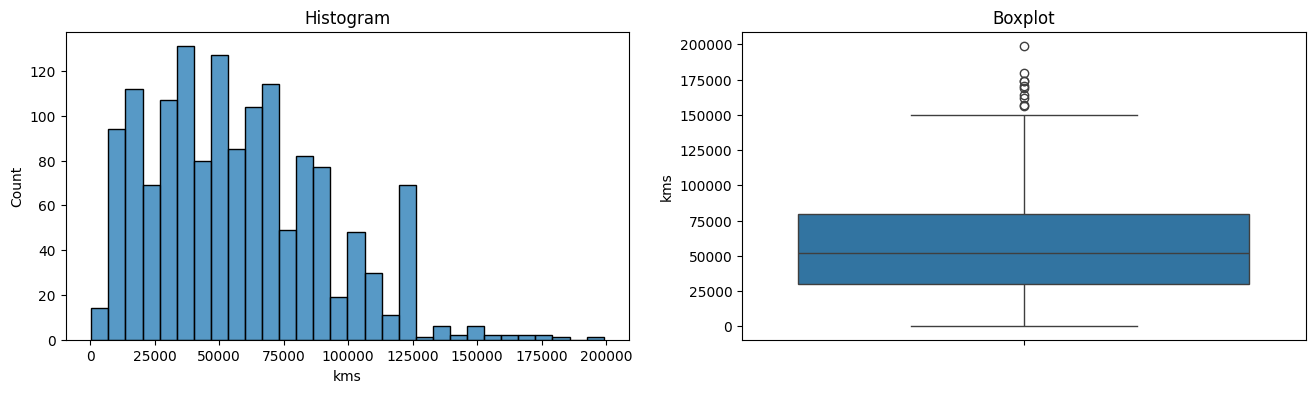

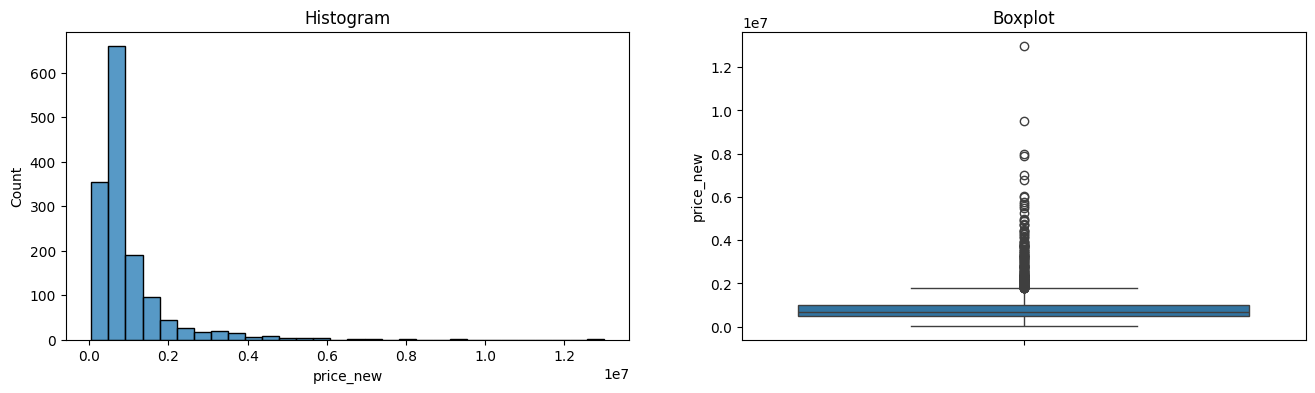

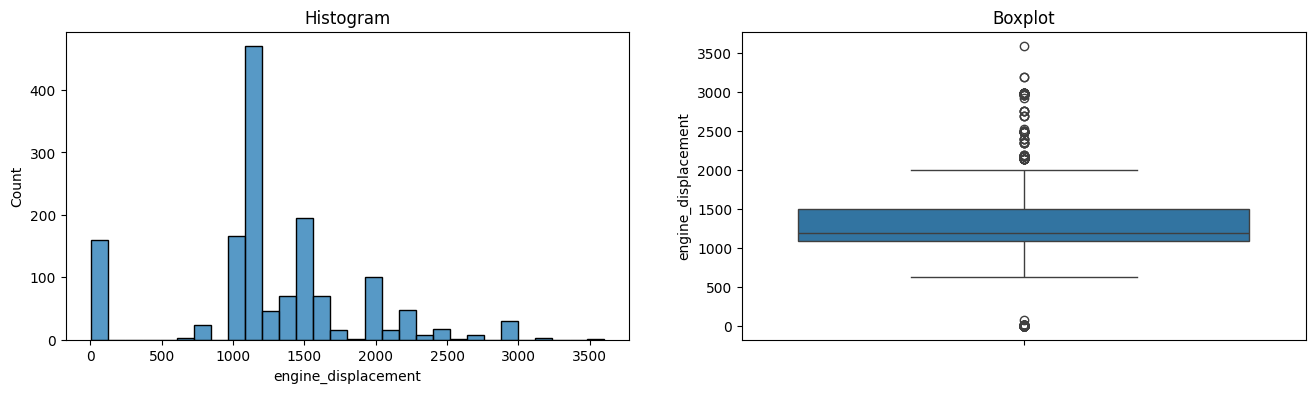

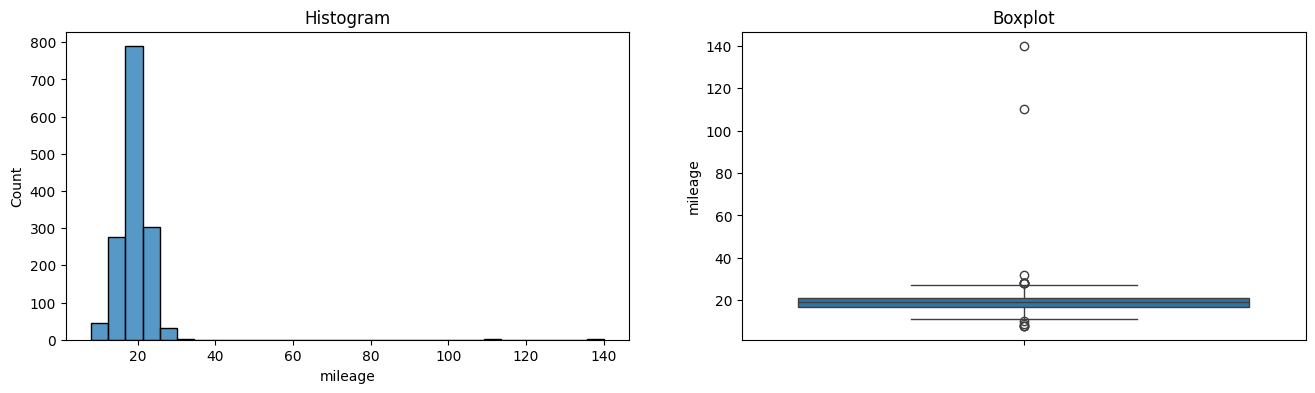

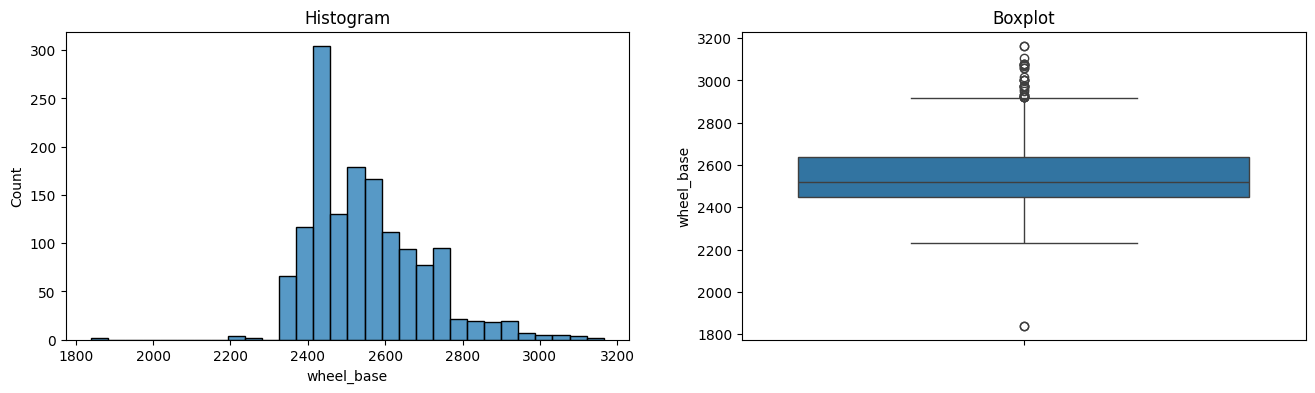

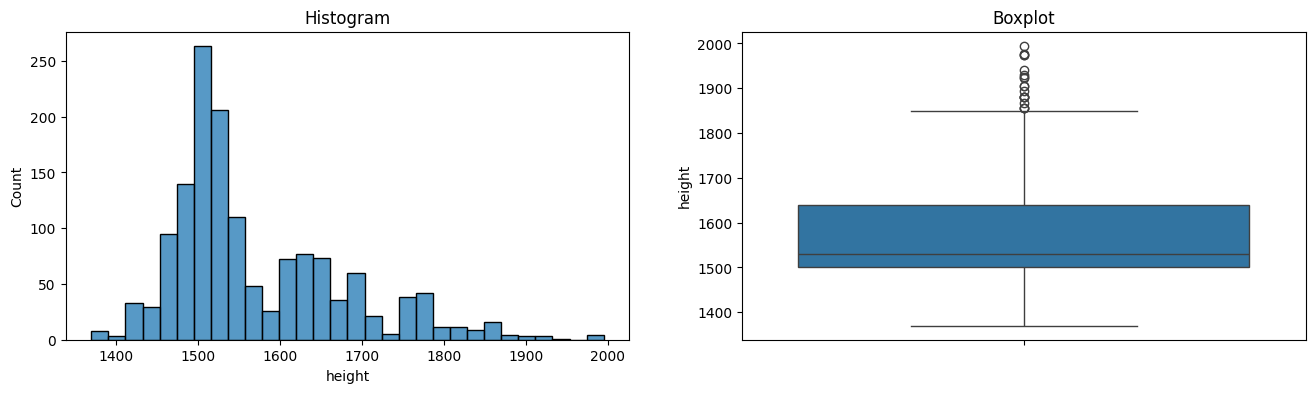

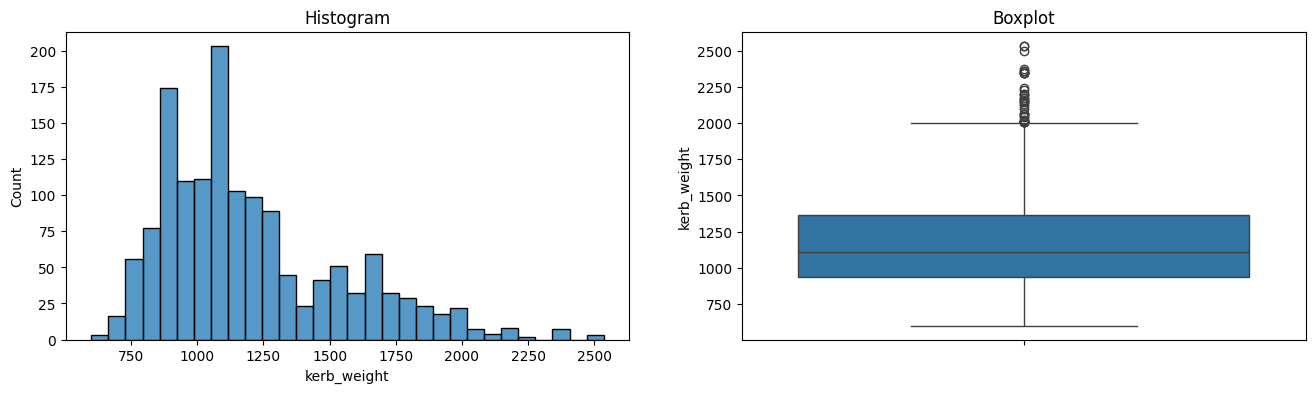

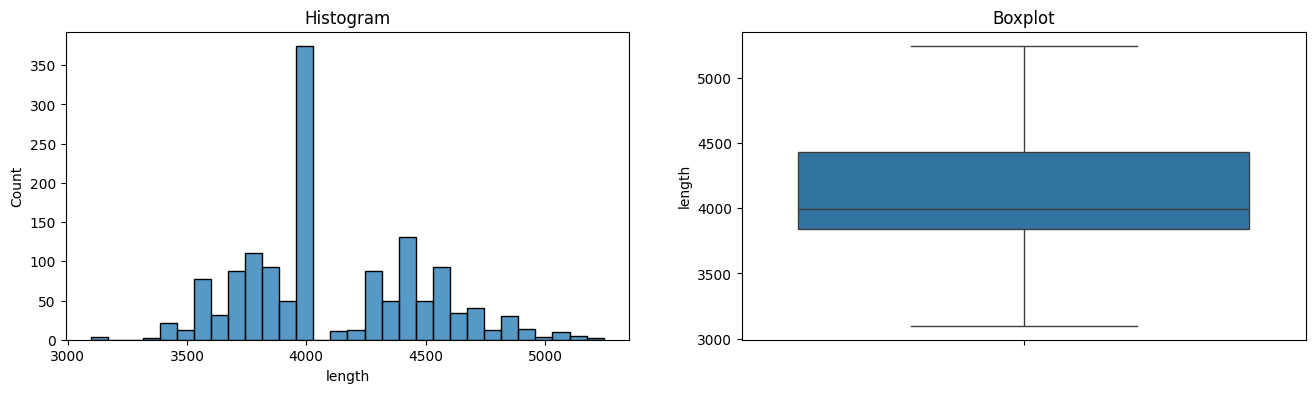

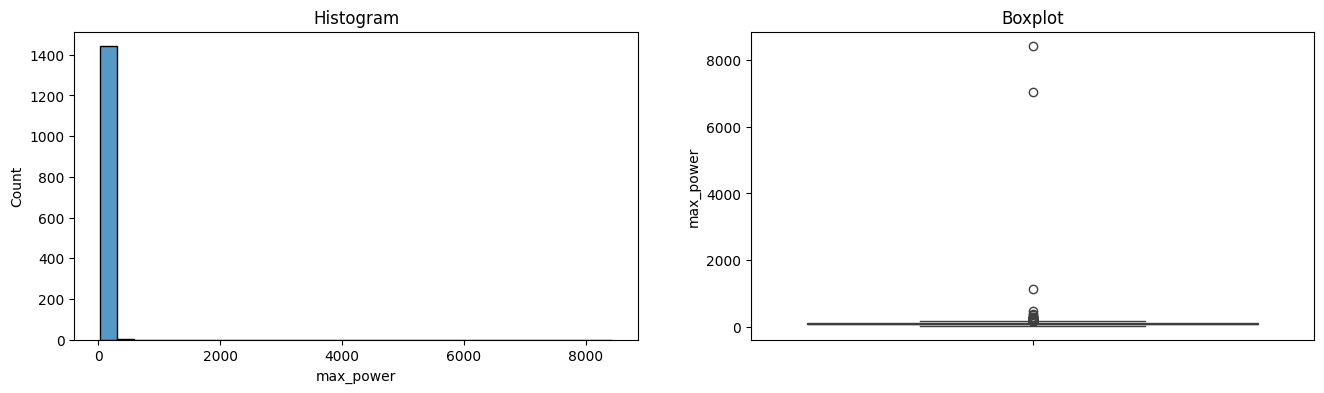

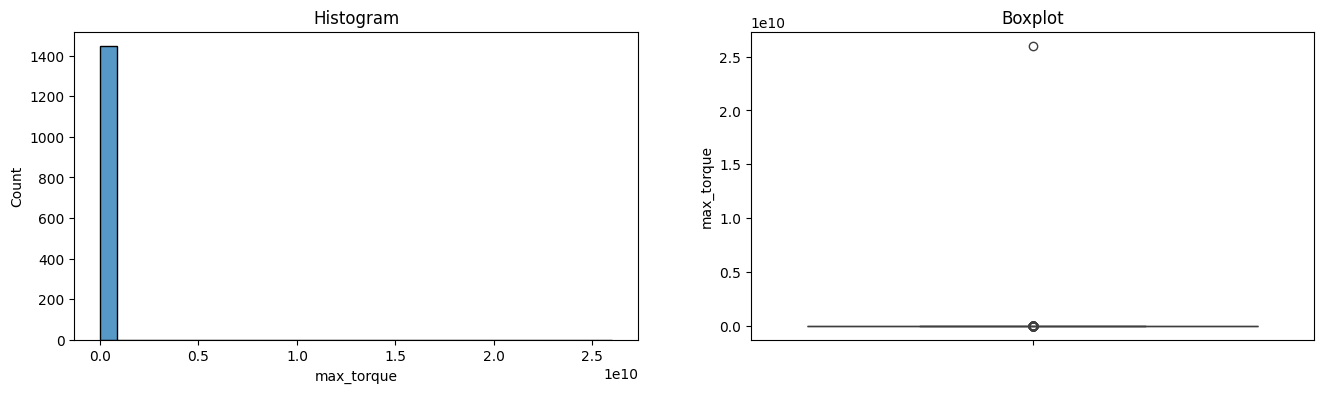

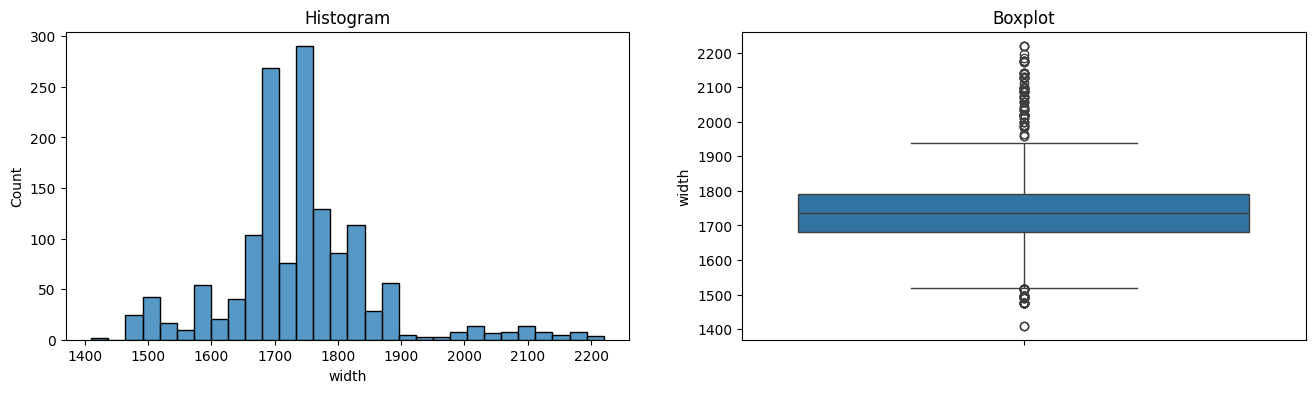

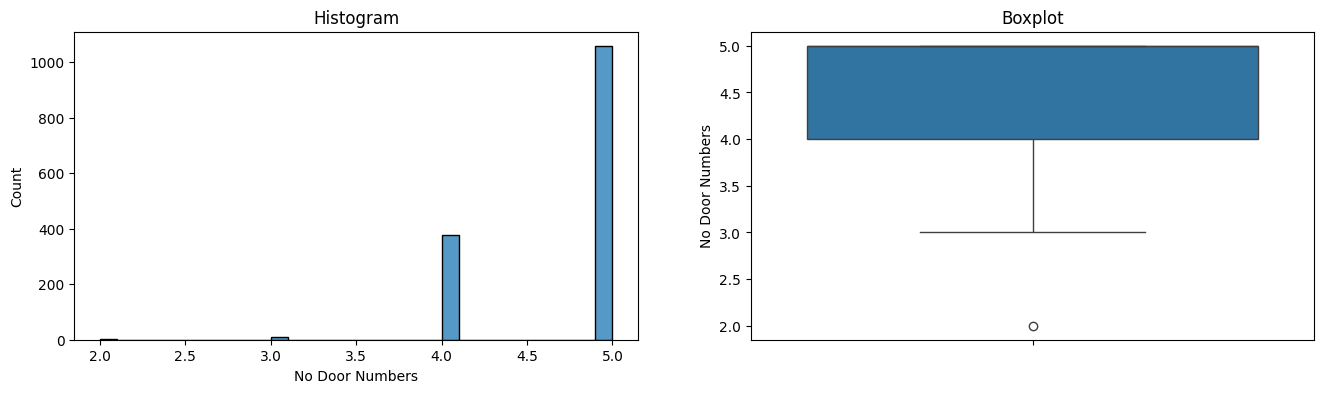

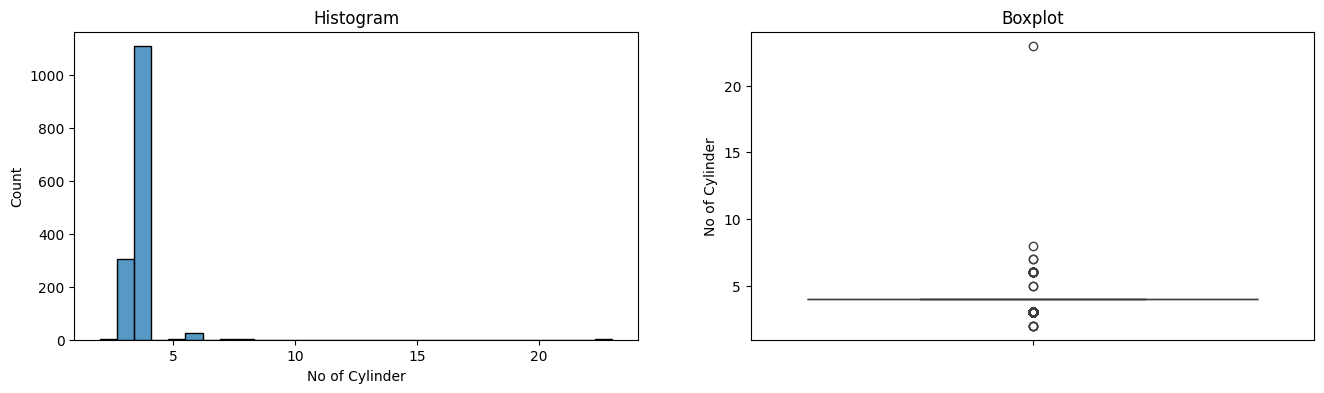

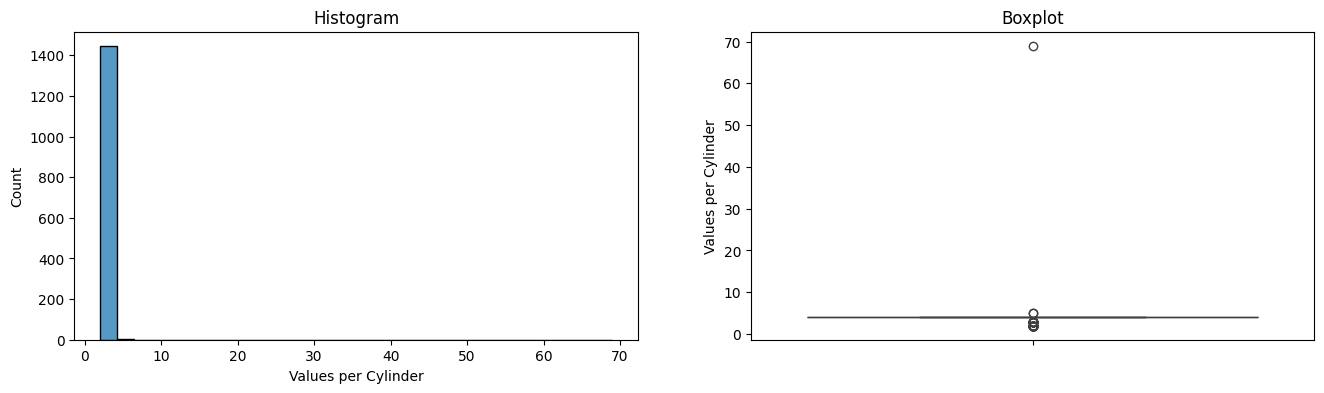

In [99]:
for m in nc:
    plots(df, m)

In [100]:
def find_skewed_boundaries(df, variable, distance):

    # Calculating the boundaries outside which sit the outliers
    # for skewed distributions


    IQR = round(df[variable].quantile(0.75) - df[variable].quantile(0.25))

    lower_boundary = abs(round(df[variable].quantile(0.25) - (IQR * distance)))
    upper_boundary = abs(round(df[variable].quantile(0.75) + (IQR * distance)))

    return upper_boundary, lower_boundary

In [101]:
ul=[]
for v in nc:
    upper_limit, lower_limit = find_skewed_boundaries(df, v, 1.5)
    ul.append((v,upper_limit, lower_limit))

In [102]:
def replace_outlier(dataset,variable,upper_limit,lower_limit):
    dataset[variable]= np.where(dataset[variable] > upper_limit, upper_limit,
                       np.where(dataset[variable] < lower_limit, lower_limit, dataset[variable]))

In [103]:
for v1 in range(len(ul)):
    replace_outlier(df,ul[v1][0],ul[v1][1],ul[v1][2])

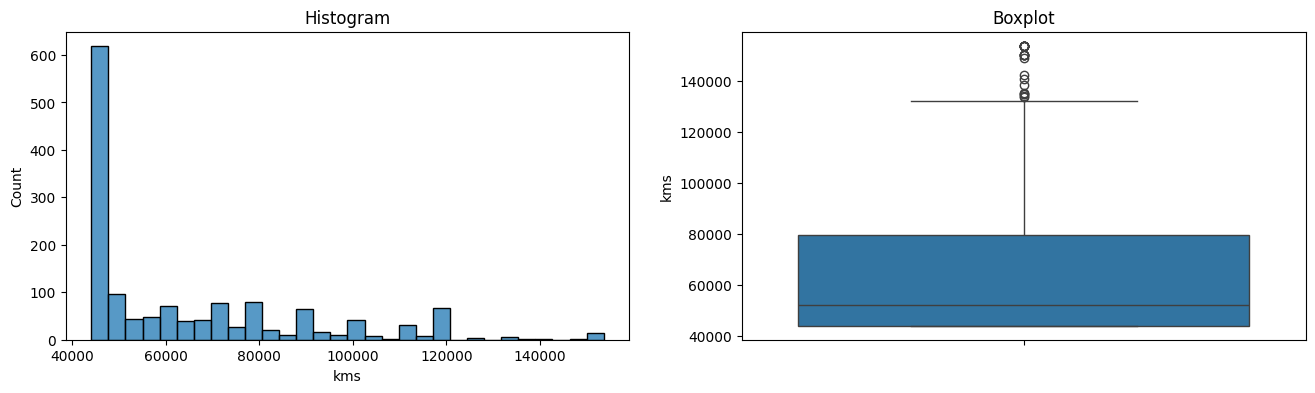

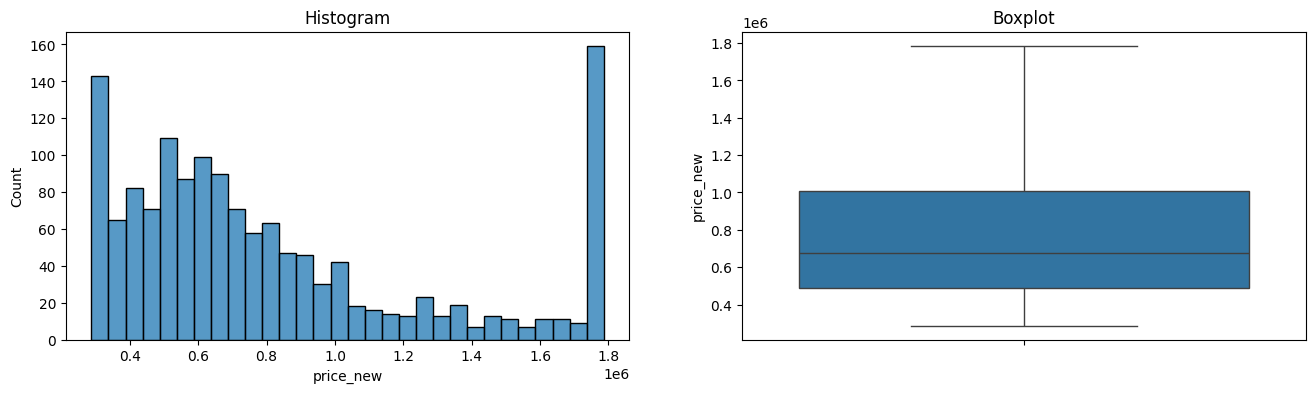

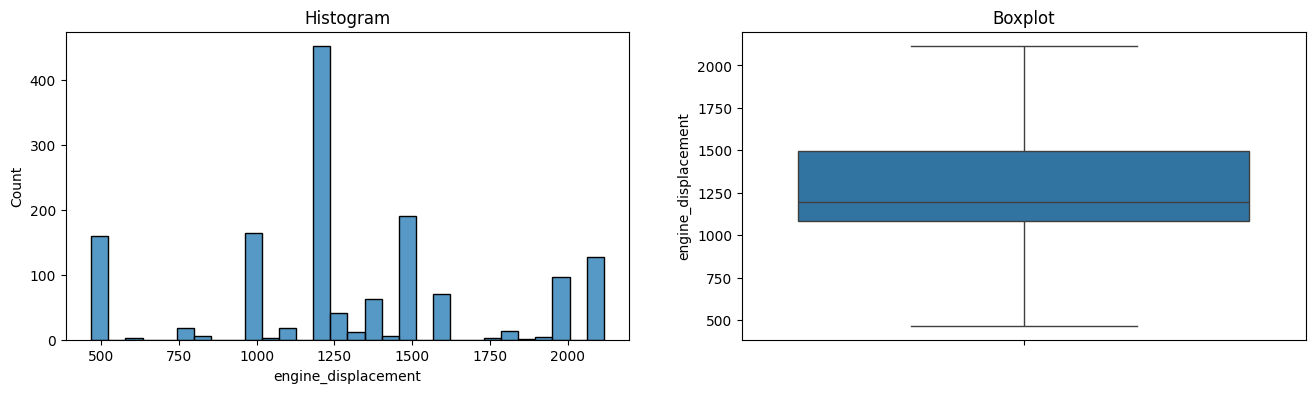

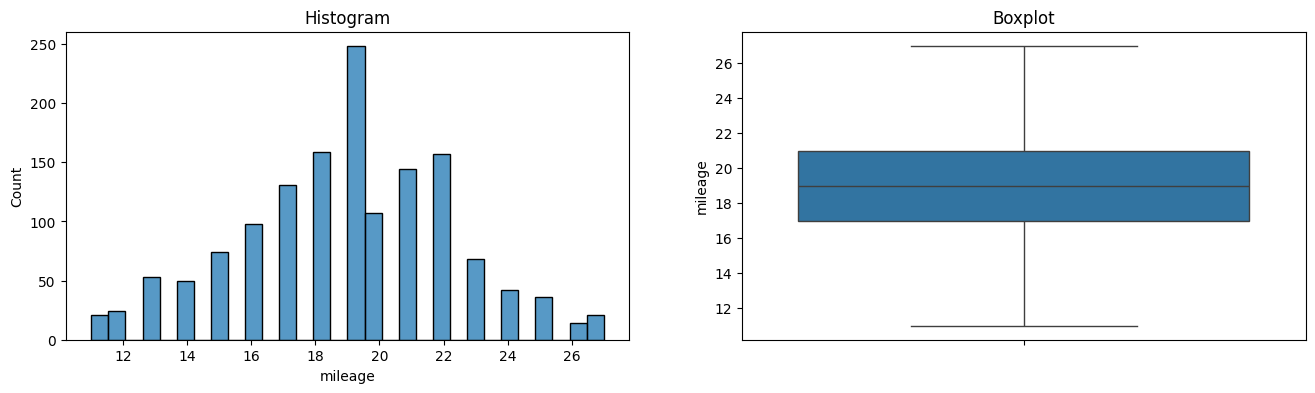

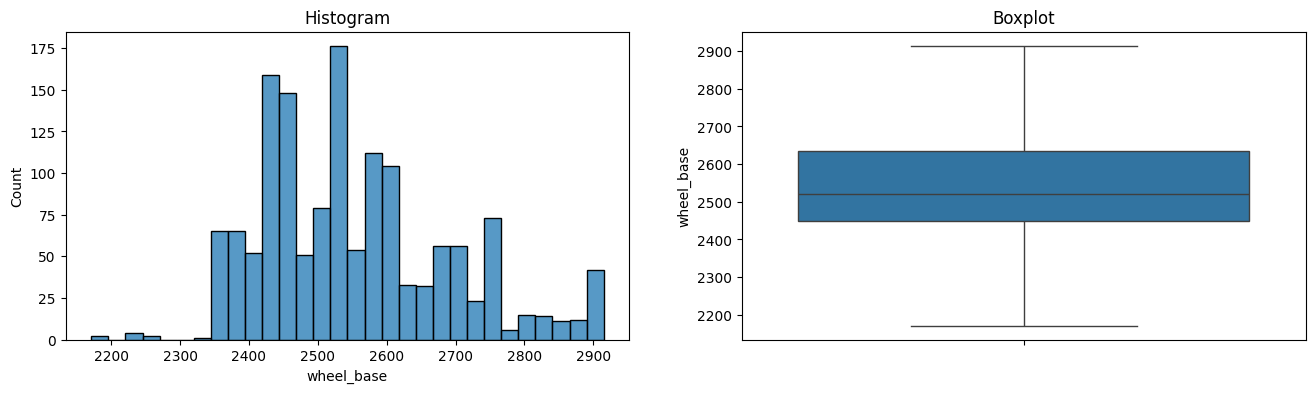

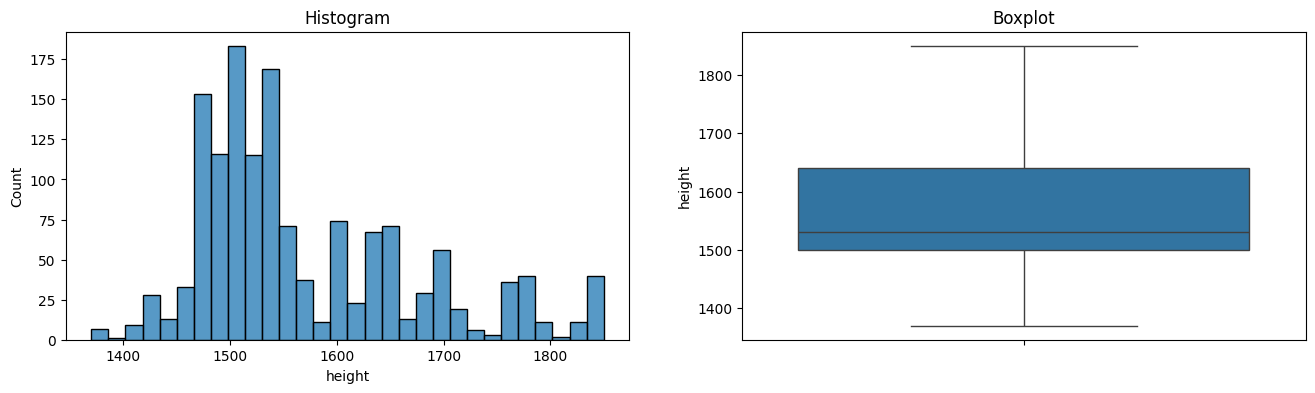

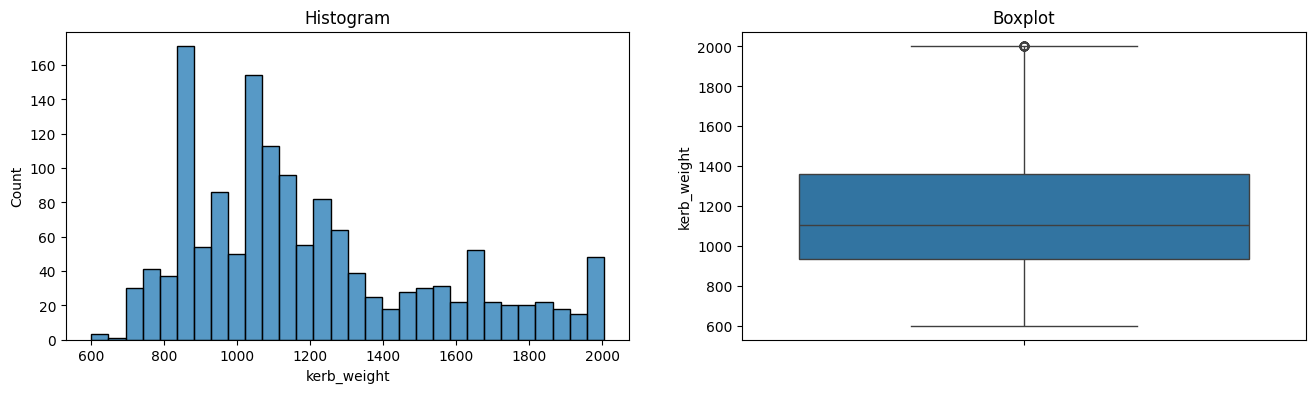

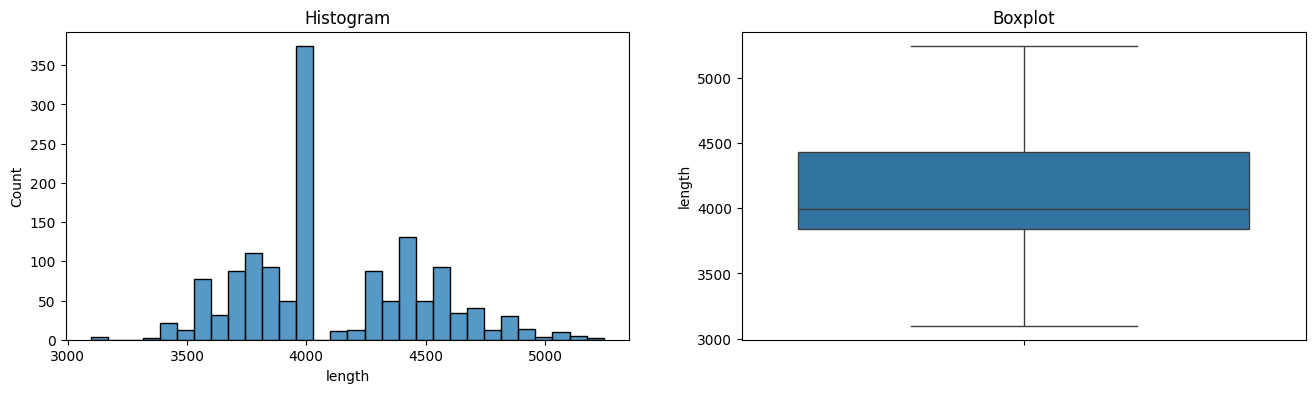

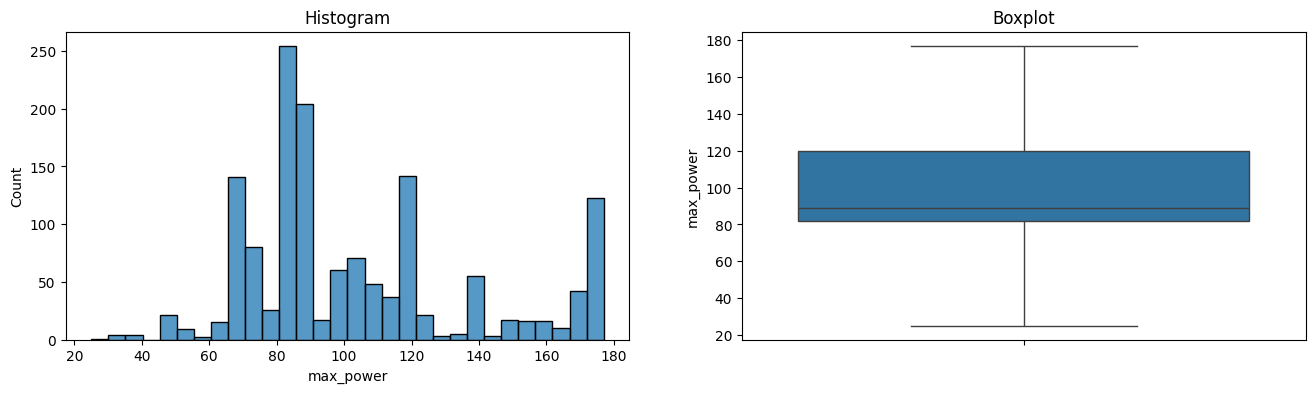

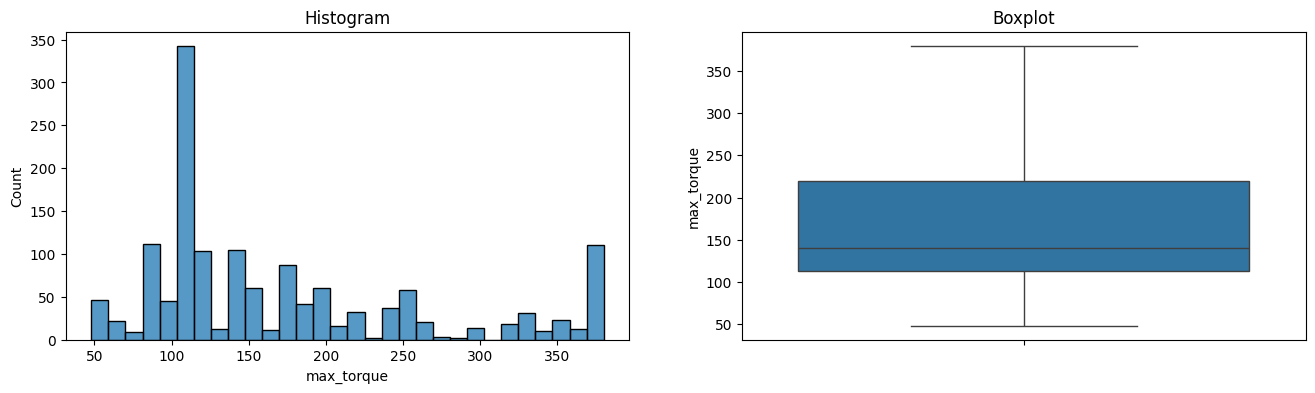

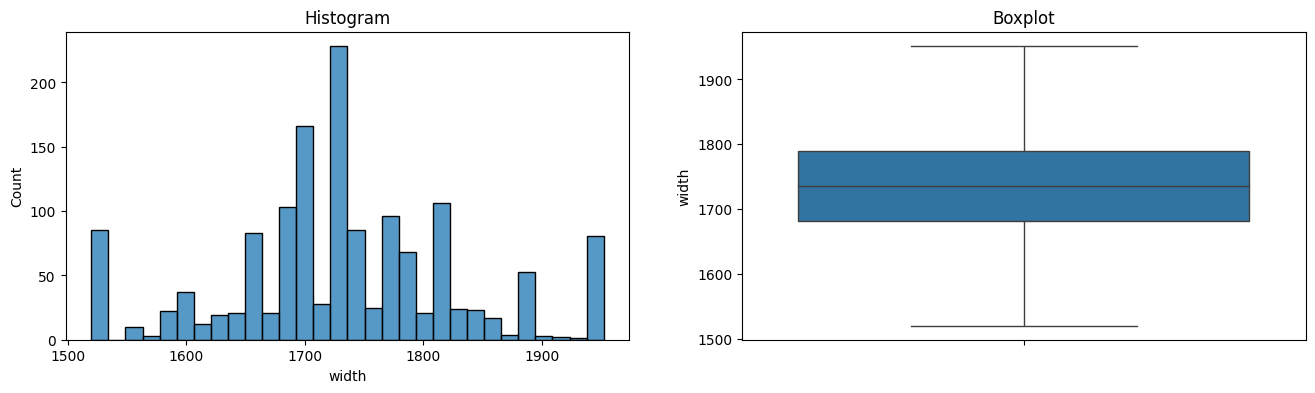

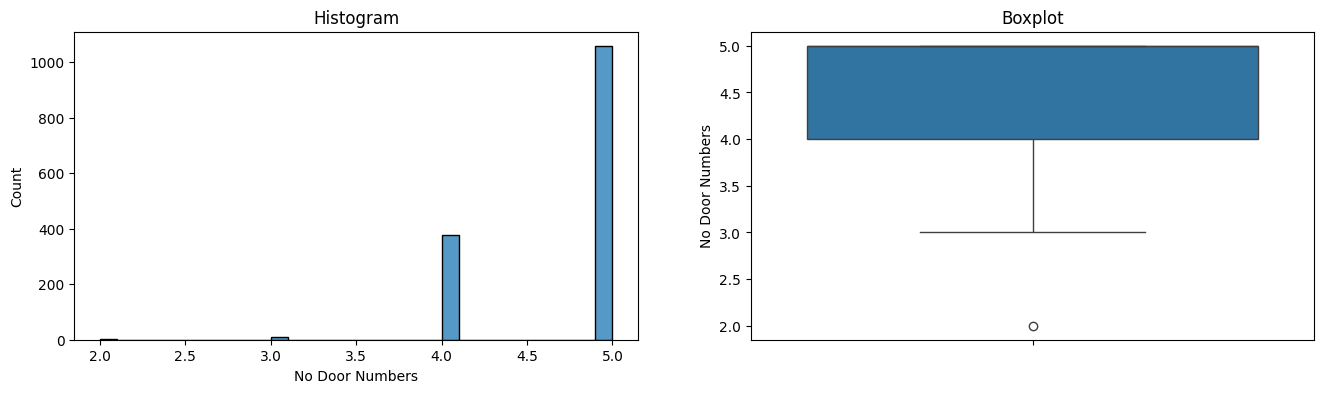

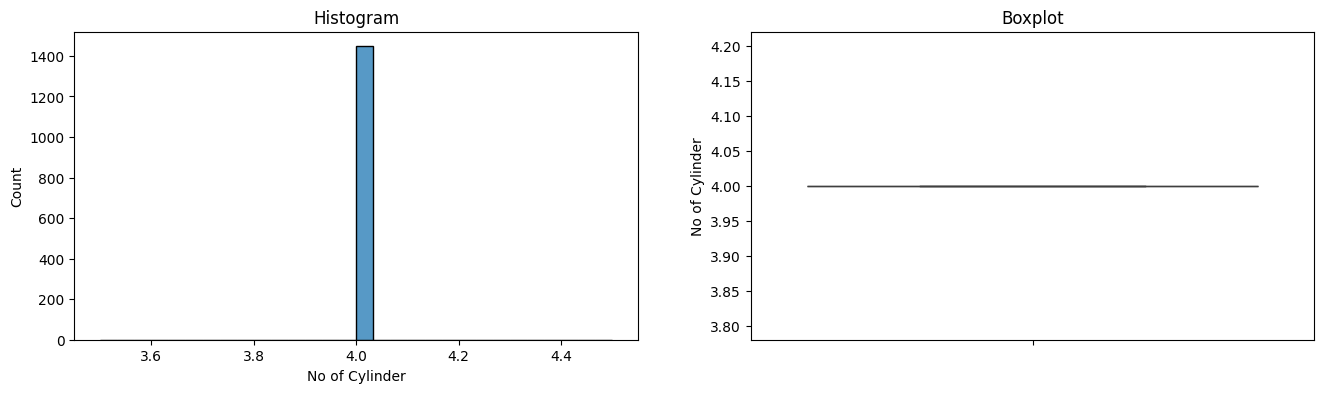

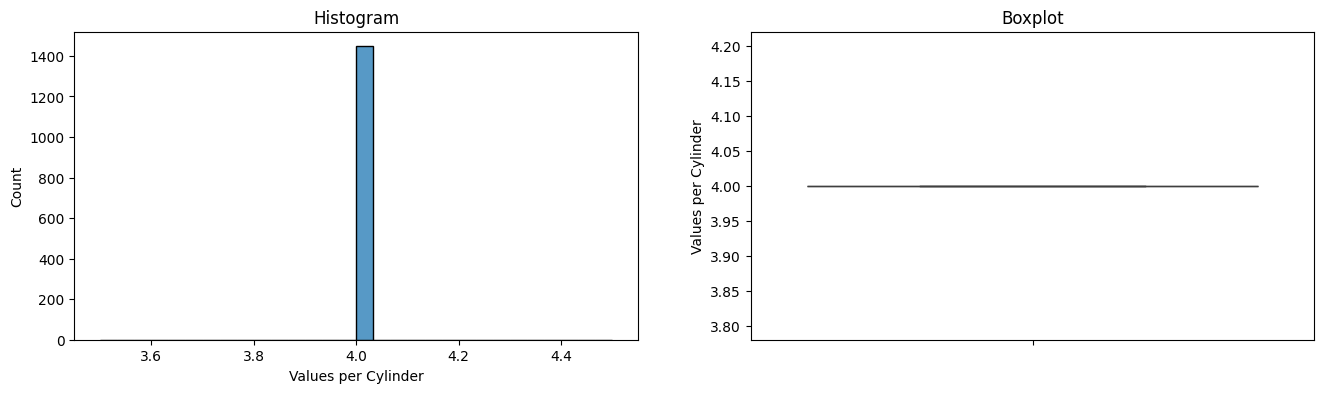

In [104]:
for m in nc:
    plots(df, m)

In [105]:
# for Q-Q plots
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer

def diagnostic_plots(df, variable):

    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable

    plt.figure(figsize=(15, 6))

    # histogram
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.title(f"Histogram of {variable}")

    # q-q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"Q-Q plot of {variable}")

    plt.show()



### Changing the distribution of the 'price_new' and 'kms' columns

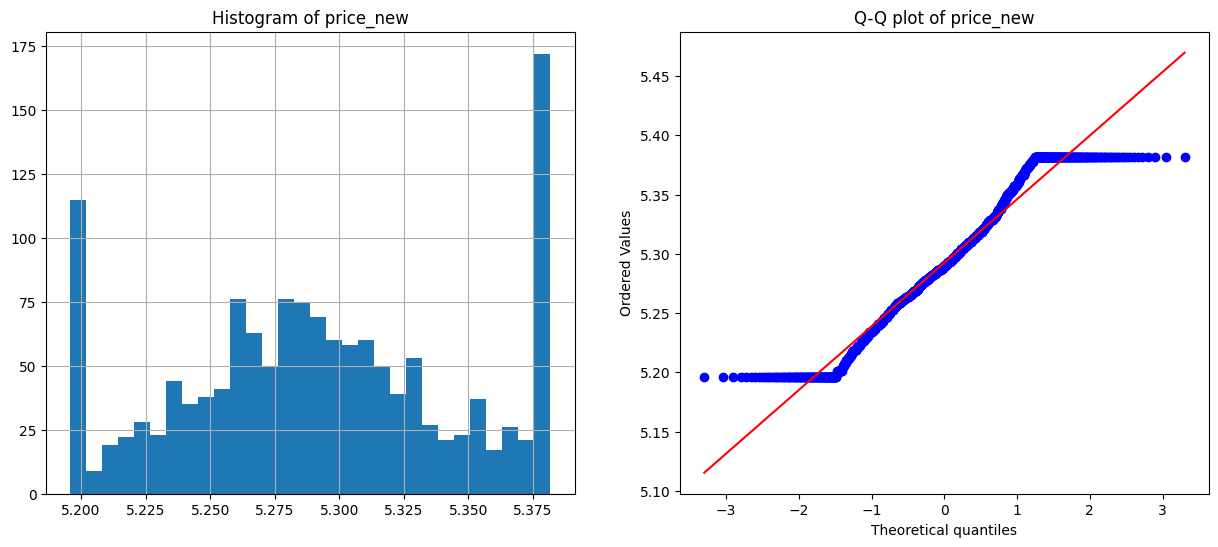

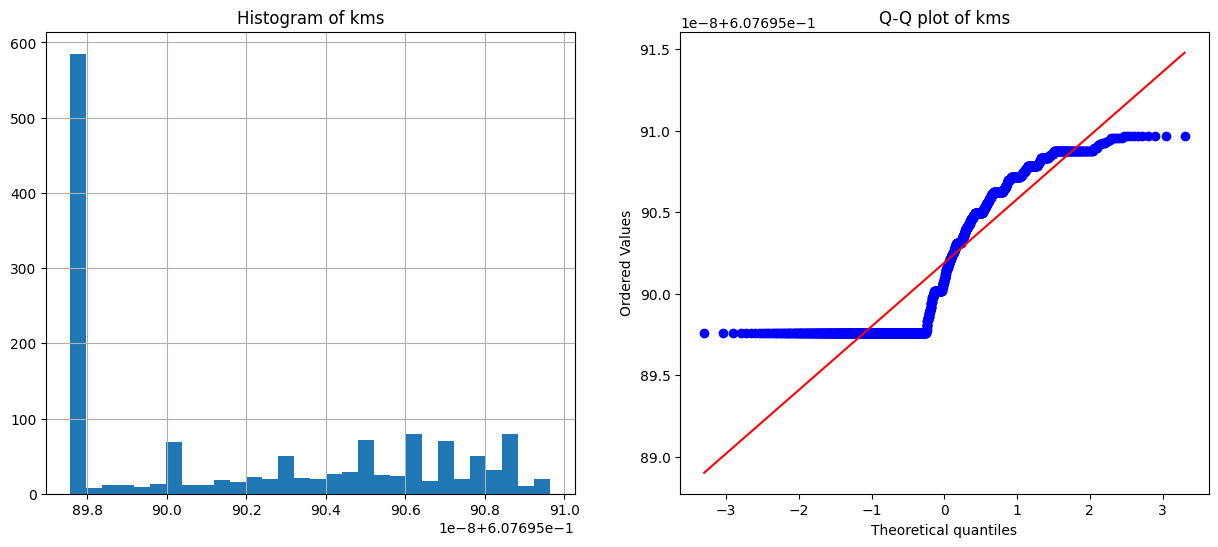

In [106]:
# with open-source packages
from sklearn.preprocessing import PowerTransformer

#transforming the ''price_new' column using "box-cox"
transformer1 = PowerTransformer(method="box-cox", standardize=False)
transformer1.fit(df[['price_new']])
# transformer1.set_output(transform="pandas")
df['price_new']= transformer1.transform(df[['price_new']])

diagnostic_plots(df, 'price_new')

#transforming the 'kms' column using "box-cox"
transformer2 = PowerTransformer(method="box-cox", standardize=False)
transformer2.fit(df[['kms']])
# transformer2.set_output(transform="pandas")
df['kms']= transformer2.transform(df[['kms']])

diagnostic_plots(df, 'kms')

In [107]:
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.encoding import MeanEncoder

In [108]:
s=new_all_selected_features.index('price_new')
s1=new_all_selected_features[s]

# Removing the 'price_new' column from 'new_all_selected_features' list
new_all_selected_features.pop(s)
new_all_selected_features

['owner',
 'oem',
 'body_type',
 'registration_year',
 'alloy_wheel_size',
 'turbo_charger',
 'front_brake_type',
 'gear_box',
 'Rear Brake Type',
 'seating_capacity',
 'kms',
 'engine_displacement',
 'mileage',
 'wheel_base',
 'height',
 'kerb_weight',
 'length',
 'max_power',
 'max_torque',
 'width',
 'No Door Numbers',
 'No of Cylinder',
 'Values per Cylinder']

In [109]:
y=df[s1]
X=df[new_all_selected_features]


X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    test_size=0.20,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1157, 23), (290, 23))

In [110]:
mean_enc = MeanEncoder(variables=cc) #cc- categorical columns

In [111]:
mean_enc.fit(X_train, y_train)

MeanEncoder(variables=['owner', 'oem', 'body_type', 'registration_year',
                       'alloy_wheel_size', 'turbo_charger', 'front_brake_type',
                       'gear_box', 'Rear Brake Type', 'seating_capacity'])

In [112]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

# let's explore the result
X_train.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\feature_engine\encoding\base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) Rear Brake Type.
  warnings.warn(


,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
979,5.303634,5.361900,5.339465,5.321496,5.284042,5.325083,5.296485,5.329666,5.278048,5.286253,...,2500.0,1642.0,1351.0,3995.0,99.0,240.0,1790.0,5.0,4.0,4.0
187,5.283039,5.285175,5.293571,5.298859,5.284042,5.269480,5.280467,5.312505,5.278048,5.286253,...,2600.0,1495.0,1107.0,4440.0,117.0,145.0,1695.0,4.0,4.0,4.0
157,5.237374,5.286786,5.293571,5.290154,5.285048,5.325083,5.296485,5.265705,5.278048,5.286253,...,2552.0,1466.0,1206.0,4386.0,103.0,250.0,1699.0,4.0,4.0,4.0
685,5.283039,5.280152,5.260107,5.298859,5.284042,5.269480,5.296485,5.265705,5.278048,5.286253,...,2570.0,1505.0,1066.0,3985.0,82.0,115.0,1734.0,5.0,4.0,4.0
9,5.303634,5.283900,5.260107,5.306497,5.284042,5.269480,5.296485,5.265705,5.278048,5.286253,...,2400.0,1535.0,1012.0,3746.0,84.0,114.0,1647.0,5.0,4.0,4.0


In [113]:
X_test.isnull().sum()

owner                  0
oem                    0
body_type              0
registration_year      0
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        1
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
dtype: int64

In [114]:
X_test['price_new']=y_test
X_test.dropna(inplace=True)
X_test.isnull().sum()

owner                  0
oem                    0
body_type              0
registration_year      0
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        0
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
price_new              0
dtype: int64

In [115]:
y_test=X_test['price_new']
X_test=X_test[new_all_selected_features]
X_test.shape

(289, 23)

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [118]:
# Let's train a linear model.

# Instantiate a linear model.
linreg = LinearRegression()

# Train the model.
linreg.fit(scaler.transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
# print('Train set')
pred_train = linreg.predict(scaler.transform(X_train))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('Linear Regression r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = linreg.predict(scaler.transform(X_test))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))
print('Linear Regression r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Linear Regression rmse: 0.01943004038017077
Linear Regression r2-score: 0.8716254591753728
Test set
Linear Regression rmse: 0.0221026339545379
Linear Regression r2-score: 0.8433739001634781



In [119]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [120]:
hr=HistGradientBoostingRegressor(learning_rate=0.05,max_leaf_nodes=300,max_depth=200,
                                               max_iter=1000,
                                               random_state=2023)
# Train the model.
hr.fit(scaler.fit_transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
print('Train set')
pred_train = hr.predict(scaler.transform(X_train))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = hr.predict(scaler.transform(X_test))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Train set
HistGradientBoostingRegressor rmse: 0.0023770342206901017
HistGradientBoostingRegressor r2-score: 0.9980786682259842
Test set
HistGradientBoostingRegressor rmse: 0.014779676913216118
HistGradientBoostingRegressor r2-score: 0.9299664805567027



### Inverse transforming the target column and comparing the 'actual' and 'predicted' values

In [121]:
u1=pd.concat([y_train,y_test],axis=0)
u2=pd.concat([pd.Series(pred_train),pd.Series(pred_test)],axis=0)

pred=transformer1.inverse_transform(pd.DataFrame(u2,columns=['price_new']))
y= transformer1.inverse_transform(u1.values.reshape(-1, 1))
x=pd.DataFrame({'rv':list(y),'pv':list(pred)})
x['residuals']=(x['rv']-x['pv'])
x['error']=(((x['rv']-x['pv']))/(x['rv']))

x['residuals_cor']=[i[0] for i in x['residuals']]
x['error_cor']=[i[0] for i in x['error']]
x.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


,rv,pv,residuals,error,residuals_cor,error_cor
0,[1327999.999999996],[1320130.4629472638],[7869.537052732194],[0.00592585621440679],7869.537053,0.005926
1,[941999.9999999981],[942971.6109112488],[-971.6109112506965],[-0.0010314340883765376],-971.610911,-0.001031
2,[499999.99999999907],[502758.6590477701],[-2758.6590477710124],[-0.0055173180955420354],-2758.659048,-0.005517
3,[614999.9999999944],[620178.0087604505],[-5178.008760456112],[-0.008419526439766113],-5178.008760,-0.008420
4,[584999.9999999971],[596576.4755899643],[-11576.475589967216],[-0.019788847162337222],-11576.475590,-0.019789


In [122]:
x['residuals'].max(),x['residuals'].min()

(array([704465.37114398]), array([-365965.20678818]))

In [123]:
round(list(x['error'].max())[0],2),round(list(x['error'].min())[0],2)

(0.4, -0.6)

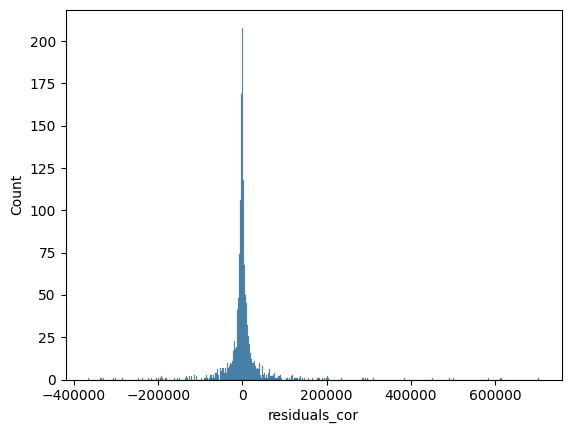

In [124]:
sns.histplot(x['residuals_cor'])
plt.show()

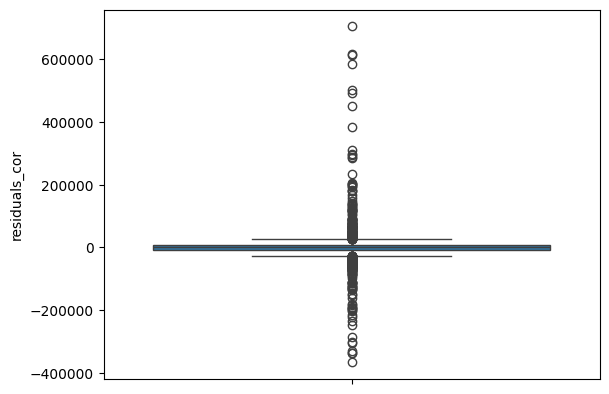

In [125]:
sns.boxplot(x['residuals_cor'])
plt.show()

In [126]:
x['residuals_cor'].describe()

count      1446.000000
mean       2515.870838
std       63301.090683
min     -365965.206788
25%       -6538.935167
50%         -95.362483
75%        6906.469003
max      704465.371144
Name: residuals_cor, dtype: float64

### From 248 features ,through various analysis and tests I used only 23 features to predict the 'price' of the cars.Hope the project results are good!!! 